In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


In [2]:
# Scrape Standard Stats
url_standard = "https://fbref.com/en/comps/11/10731/stats/2024-2025-Serie-A-Stats"
res = requests.get(url_standard)
soup = BeautifulSoup(res.text, 'lxml')
comments = soup.find_all(string=lambda text: isinstance(text, (str, bytes)) and 'table' in text)
target_comment = None
for c in comments:
    if 'id="stats_standard"' in c:
        target_comment = c
        break
if target_comment is not None:
    table_soup = BeautifulSoup(target_comment, 'lxml')
    table = table_soup.find('table')
    df_std = pd.read_html(str(table))[0]
else:
    raise Exception("Could not find stats_standard table in comments.")
df_std.columns = [
    '_'.join(col).strip().replace('Unnamed: ', '').replace('_level_0', '')
    if isinstance(col, tuple) else col
    for col in df_std.columns.values
]
rename_dict = {
    '0_Rk': 'Rk',
    '1_Player': 'Player',
    '2_Nation': 'Nation',
    '3_Pos': 'Pos',
    '4_Squad': 'Squad',
    '5_Age': 'Age',
    '6_Born': 'Born'
}
df_std = df_std.rename(columns=rename_dict)
df_std = df_std[df_std['Player'] != 'Player'].reset_index(drop=True)

# Scrape Shooting Stats
url_shoot = "https://fbref.com/en/comps/11/10731/shooting/2024-2025-Serie-A-Stats"
res = requests.get(url_shoot)
soup = BeautifulSoup(res.text, 'lxml')
comments = soup.find_all(string=lambda text: isinstance(text, (str, bytes)) and 'table' in text)
shooting_comment = None
for c in comments:
    if 'id="stats_shooting"' in c:
        shooting_comment = c
        break
if shooting_comment is not None:
    shooting_table_soup = BeautifulSoup(shooting_comment, 'lxml')
    shooting_table = shooting_table_soup.find('table')
    df_shoot = pd.read_html(str(shooting_table))[0]
else:
    raise Exception("Could not find stats_shooting table in comments.")
df_shoot.columns = [
    '_'.join(col).strip().replace('Unnamed: ', '').replace('_level_0', '')
    if isinstance(col, tuple) else col
    for col in df_shoot.columns.values
]
rename_dict_shoot = {
    '0_Rk': 'Rk',
    '1_Player': 'Player',
    '2_Nation': 'Nation',
    '3_Pos': 'Pos',
    '4_Squad': 'Squad',
    '5_Age': 'Age',
    '6_Born': 'Born'
}
df_shoot = df_shoot.rename(columns=rename_dict_shoot)
df_shoot = df_shoot[df_shoot['Player'] != 'Player'].reset_index(drop=True)

# Save locally for reuse
df_std.to_csv('seriea_standard_stats.csv', index=False)
df_shoot.to_csv('seriea_shooting_stats.csv', index=False)


In [3]:
df_std = pd.read_csv('seriea_standard_stats.csv')
df_shoot = pd.read_csv('seriea_shooting_stats.csv')


                  Player       Squad  Goals  Shots  Shot_Conversion   SoT_pct  \
101    Randal Kolo Muani    Juventus      8     25         0.320000  0.520000   
54           Assane Diao        Como      8     28         0.285714  0.464286   
171  Alexis Saelemaekers        Roma      7     25         0.280000  0.480000   
153                Pedro       Lazio     10     37         0.270270  0.432432   
170        Mateo Retegui    Atalanta     25     99         0.252525  0.323232   
81    Albert Guðmundsson  Fiorentina      6     25         0.240000  0.520000   
200         Timothy Weah    Juventus      5     21         0.238095  0.428571   
115        Romelu Lukaku      Napoli     14     60         0.233333  0.333333   
53           Boulaye Dia       Lazio      9     39         0.230769  0.487179   
79      Santiago Giménez       Milan      5     22         0.227273  0.409091   

     Goals_per90  
101     0.620690  
54      0.575080  
171     0.453564  
153     0.816697  
170     0.944

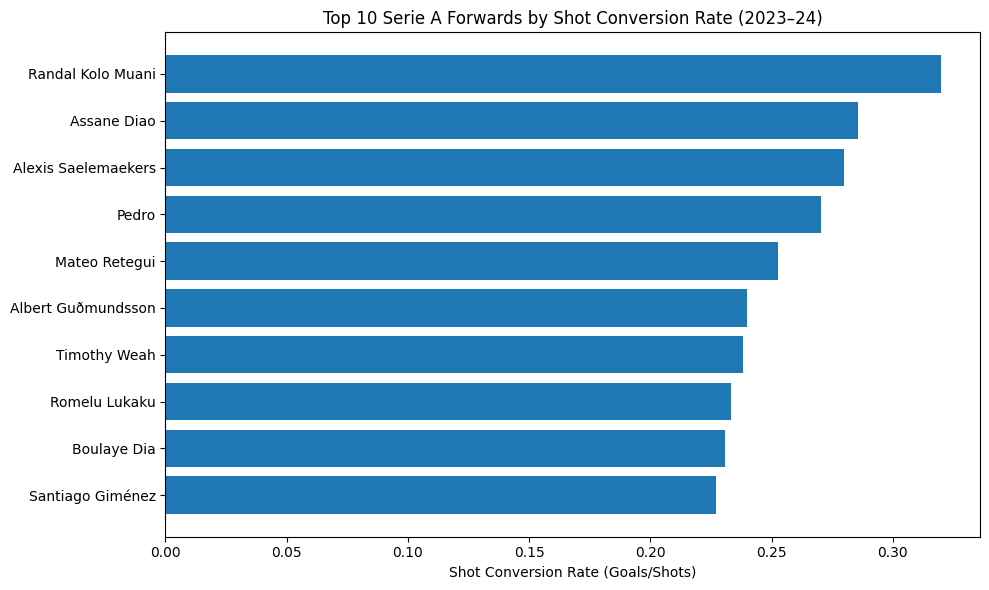

In [7]:
# Filter for forwards
df_fw = df_std[df_std['Pos'].str.contains('FW', na=False)].copy()

# Merge
df_merged = pd.merge(
    df_fw,
    df_shoot[['Player', 'Squad', 'Standard_Sh', 'Standard_SoT', 'Standard_Gls', 'Standard_PK', 'Standard_PKatt']],
    on=['Player', 'Squad'],
    how='left'
)

# Calculate metrics
df_merged['Min'] = pd.to_numeric(df_merged['Playing Time_Min'], errors='coerce')
df_merged['Goals'] = pd.to_numeric(df_merged['Performance_Gls'], errors='coerce')
df_merged['Shots'] = pd.to_numeric(df_merged['Standard_Sh'], errors='coerce')
df_merged['SoT'] = pd.to_numeric(df_merged['Standard_SoT'], errors='coerce')
df_merged['Goals_per90'] = df_merged['Goals'] / (df_merged['Min'] / 90)
df_merged['Shot_Conversion'] = df_merged['Goals'] / df_merged['Shots']
df_merged['SoT_pct'] = df_merged['SoT'] / df_merged['Shots']

# Top forwards by shot conversion rate
df_top_conversion = df_merged[df_merged['Shots'] >= 20].sort_values('Shot_Conversion', ascending=False)

print(df_top_conversion[['Player', 'Squad', 'Goals', 'Shots', 'Shot_Conversion', 'SoT_pct', 'Goals_per90']].head(10))

# Visualization
plt.figure(figsize=(10,6))
plt.barh(
    df_top_conversion.head(10)['Player'][::-1],
    df_top_conversion.head(10)['Shot_Conversion'][::-1]
)
plt.xlabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Top 10 Serie A Forwards by Shot Conversion Rate (2023–24)')
plt.tight_layout()
plt.show()


In [8]:
# Example: For each team, top forward by shot conversion (min 20 shots)
top_by_team = (
    df_top_conversion
    .sort_values(['Squad', 'Shot_Conversion'], ascending=[True, False])
    .groupby('Squad')
    .head(1)
)
print(top_by_team[['Squad', 'Player', 'Goals', 'Shots', 'Shot_Conversion', 'Goals_per90']])


             Squad               Player  Goals  Shots  Shot_Conversion  \
170       Atalanta        Mateo Retegui     25     99         0.252525   
149        Bologna    Riccardo Orsolini     15     72         0.208333   
159       Cagliari      Roberto Piccoli     10     97         0.103093   
54            Como          Assane Diao      8     28         0.285714   
66          Empoli  Sebastiano Esposito      8     59         0.135593   
81      Fiorentina   Albert Guðmundsson      6     25         0.240000   
161          Genoa     Andrea Pinamonti     10     78         0.128205   
177  Hellas Verona            Amin Sarr      4     23         0.173913   
192          Inter        Marcus Thuram     14     64         0.218750   
101       Juventus    Randal Kolo Muani      8     25         0.320000   
153          Lazio                Pedro     10     37         0.270270   
160          Lecce    Santiago Pierotti      4     32         0.125000   
79           Milan     Santiago Giméne

In [9]:
team_name = "Inter"  # Replace with any team, or loop through df_top_conversion['Squad'].unique()
print(
    df_top_conversion[df_top_conversion['Squad'] == team_name]
    [['Player', 'Goals', 'Shots', 'Shot_Conversion', 'Goals_per90']]
    .sort_values('Shot_Conversion', ascending=False)
)


               Player  Goals  Shots  Shot_Conversion  Goals_per90
192     Marcus Thuram     14     64         0.218750     0.572727
60    Denzel Dumfries      7     36         0.194444     0.337802
124  Lautaro Martínez     12     99         0.121212     0.436540
55   Federico Dimarco      4     55         0.072727     0.168224


In [10]:
# Mean conversion per team
team_summary = (
    df_top_conversion
    .groupby('Squad')
    .agg(
        Num_Forwards=('Player', 'count'),
        Total_Goals=('Goals', 'sum'),
        Avg_Shot_Conv=('Shot_Conversion', 'mean'),
        Avg_Goals_per90=('Goals_per90', 'mean')
    )
    .sort_values('Avg_Shot_Conv', ascending=False)
)
print(team_summary.head(10))


            Num_Forwards  Total_Goals  Avg_Shot_Conv  Avg_Goals_per90
Squad                                                                
Atalanta               3           47       0.194515         0.616446
Roma                   5           30       0.158462         0.343528
Inter                  4           37       0.151783         0.378823
Lazio                  6           42       0.147957         0.355600
Juventus               7           39       0.146133         0.307624
Fiorentina             5           31       0.141675         0.296888
Bologna                6           43       0.136098         0.348345
Milan                  7           35       0.135765         0.330242
Napoli                 5           30       0.120154         0.310272
Monza                  4           15       0.119257         0.216905


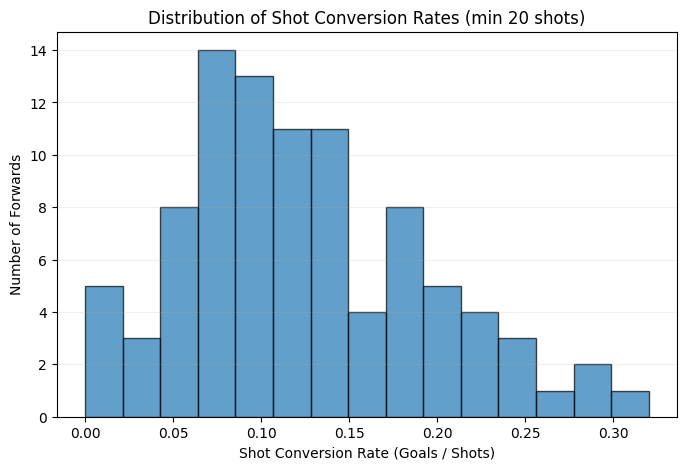

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(df_top_conversion['Shot_Conversion'].dropna(), bins=15, edgecolor='black', alpha=0.7)
plt.xlabel('Shot Conversion Rate (Goals / Shots)')
plt.ylabel('Number of Forwards')
plt.title('Distribution of Shot Conversion Rates (min 20 shots)')
plt.grid(axis='y', alpha=0.2)
plt.show()


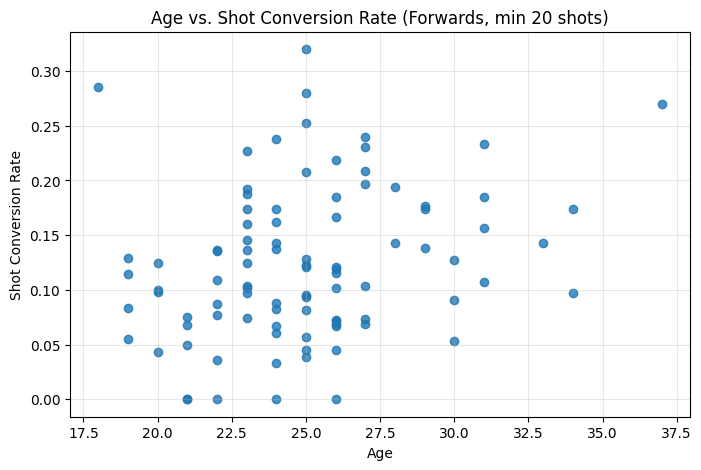

Correlation between Age and Shot Conversion: 0.27


In [13]:
# Convert Age to numeric if not already
df_top_conversion['Age'] = pd.to_numeric(df_top_conversion['Age'], errors='coerce')

plt.figure(figsize=(8,5))
plt.scatter(df_top_conversion['Age'], df_top_conversion['Shot_Conversion'], alpha=0.8)
plt.xlabel('Age')
plt.ylabel('Shot Conversion Rate')
plt.title('Age vs. Shot Conversion Rate (Forwards, min 20 shots)')
plt.grid(alpha=0.3)
plt.show()

# Optional: Add correlation
corr = df_top_conversion[['Age', 'Shot_Conversion']].corr().iloc[0,1]
print(f'Correlation between Age and Shot Conversion: {corr:.2f}')


Top 10 overperformers by Goals vs xG:
                  Player     Squad  Goals    xG  xG_diff
170        Mateo Retegui  Atalanta     25  18.9      6.1
149    Riccardo Orsolini   Bologna     15  10.1      4.9
153                Pedro     Lazio     10   5.3      4.7
113      Ademola Lookman  Atalanta     15  10.3      4.7
171  Alexis Saelemaekers      Roma      7   2.5      4.5
114        Lorenzo Lucca   Udinese     12   7.6      4.4
192        Marcus Thuram     Inter     14   9.9      4.1
54           Assane Diao      Como      8   4.0      4.0
101    Randal Kolo Muani  Juventus      8   4.7      3.3
202         Kenan Yıldız  Juventus      7   4.3      2.7
Top 10 underperformers by Goals vs xG:
                   Player       Squad  Goals    xG  xG_diff
1           Tammy Abraham       Milan      3   7.1     -4.1
33   Valentín Castellanos       Lazio     10  13.4     -3.4
18        Ange-Yoan Bonny       Parma      6   9.4     -3.4
152           Nicolás Paz        Como      6   9.3     -

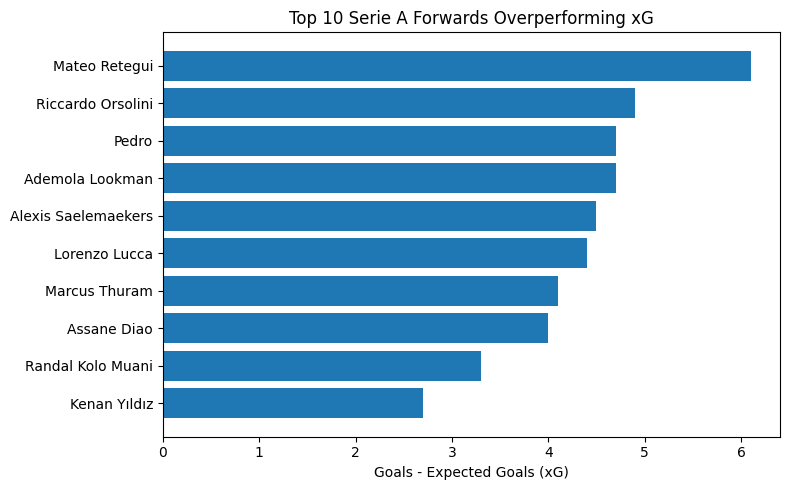

In [14]:
# Compute xG difference (actual - expected)
df_top_conversion['xG'] = pd.to_numeric(df_top_conversion['Expected_xG'], errors='coerce')
df_top_conversion['xG_diff'] = df_top_conversion['Goals'] - df_top_conversion['xG']

# Top 10 overperformers
print("Top 10 overperformers by Goals vs xG:")
print(df_top_conversion.sort_values('xG_diff', ascending=False)[['Player', 'Squad', 'Goals', 'xG', 'xG_diff']].head(10))

# Top 10 underperformers
print("Top 10 underperformers by Goals vs xG:")
print(df_top_conversion.sort_values('xG_diff')[['Player', 'Squad', 'Goals', 'xG', 'xG_diff']].head(10))

# Visualize
plt.figure(figsize=(8,5))
plt.barh(df_top_conversion.sort_values('xG_diff', ascending=False).head(10)['Player'][::-1],
         df_top_conversion.sort_values('xG_diff', ascending=False).head(10)['xG_diff'][::-1])
plt.xlabel('Goals - Expected Goals (xG)')
plt.title('Top 10 Serie A Forwards Overperforming xG')
plt.tight_layout()
plt.show()


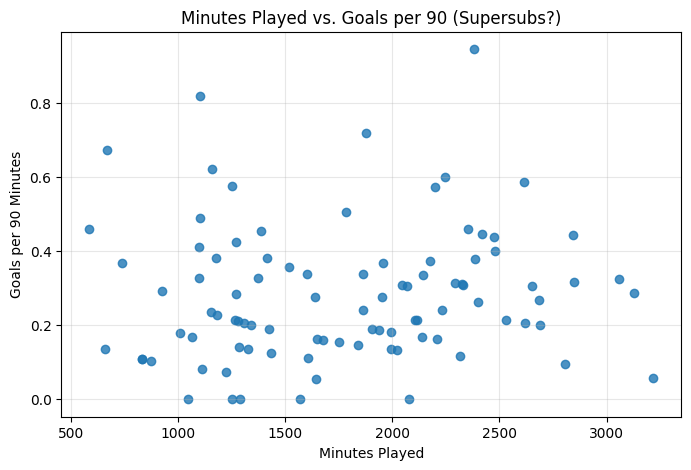

Potential supersubs:
              Player  Squad  Min  Goals_per90  Goals
79  Santiago Giménez  Milan  669     0.672646      5


In [15]:
plt.figure(figsize=(8,5))
plt.scatter(df_top_conversion['Min'], df_top_conversion['Goals_per90'], alpha=0.8)
plt.xlabel('Minutes Played')
plt.ylabel('Goals per 90 Minutes')
plt.title('Minutes Played vs. Goals per 90 (Supersubs?)')
plt.grid(alpha=0.3)
plt.show()

# Highlight players with <1000 minutes and high Goals_per90 (possible supersubs)
supersubs = df_top_conversion[(df_top_conversion['Min'] < 1000) & (df_top_conversion['Goals_per90'] > 0.5)]
print("Potential supersubs:")
print(supersubs[['Player', 'Squad', 'Min', 'Goals_per90', 'Goals']])


Top 10 forwards by goal involvement per 90:
                Player     Squad  Goals  Ast  Goal_Involvement_per90
170      Mateo Retegui  Atalanta     25    8                1.246328
79    Santiago Giménez     Milan      5    2                0.941704
149  Riccardo Orsolini   Bologna     15    4                0.910543
153              Pedro     Lazio     10    1                0.898367
113    Ademola Lookman  Atalanta     15    5                0.801068
115      Romelu Lukaku    Napoli     14   10                0.759761
192      Marcus Thuram     Inter     14    4                0.736364
166  Christian Pulisic     Milan     11    9                0.726392
197     Dušan Vlahović  Juventus     10    4                0.706278
101  Randal Kolo Muani  Juventus      8    1                0.698276


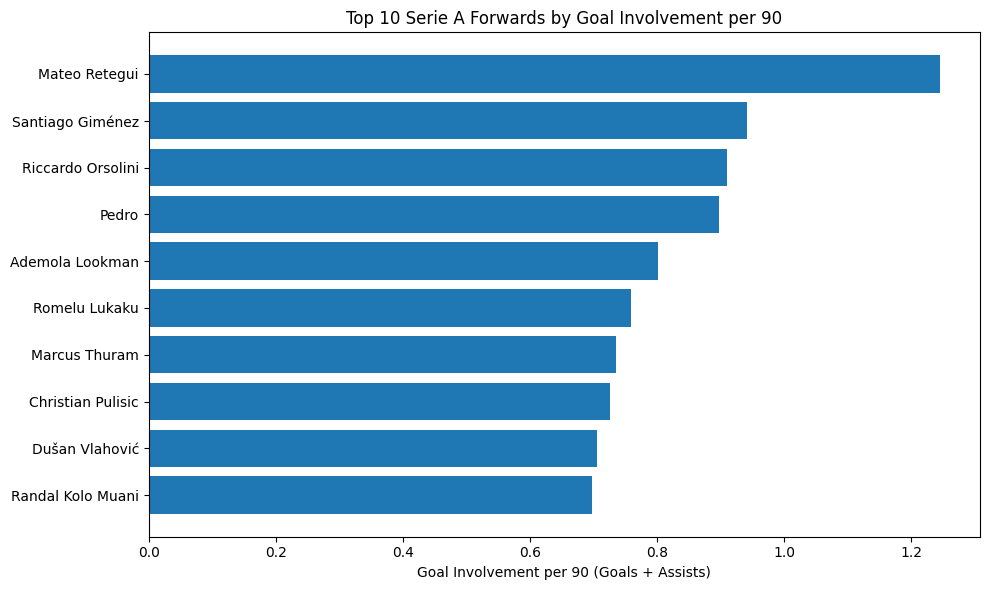

In [16]:
df_top_conversion['Ast'] = pd.to_numeric(df_top_conversion['Performance_Ast'], errors='coerce')
df_top_conversion['Goal_Involvement_per90'] = (df_top_conversion['Goals'] + df_top_conversion['Ast']) / (df_top_conversion['Min'] / 90)

print("Top 10 forwards by goal involvement per 90:")
print(
    df_top_conversion.sort_values('Goal_Involvement_per90', ascending=False)
    [['Player', 'Squad', 'Goals', 'Ast', 'Goal_Involvement_per90']]
    .head(10)
)

# Plot
plt.figure(figsize=(10,6))
plt.barh(
    df_top_conversion.sort_values('Goal_Involvement_per90', ascending=False).head(10)['Player'][::-1],
    df_top_conversion.sort_values('Goal_Involvement_per90', ascending=False).head(10)['Goal_Involvement_per90'][::-1]
)
plt.xlabel('Goal Involvement per 90 (Goals + Assists)')
plt.title('Top 10 Serie A Forwards by Goal Involvement per 90')
plt.tight_layout()
plt.show()


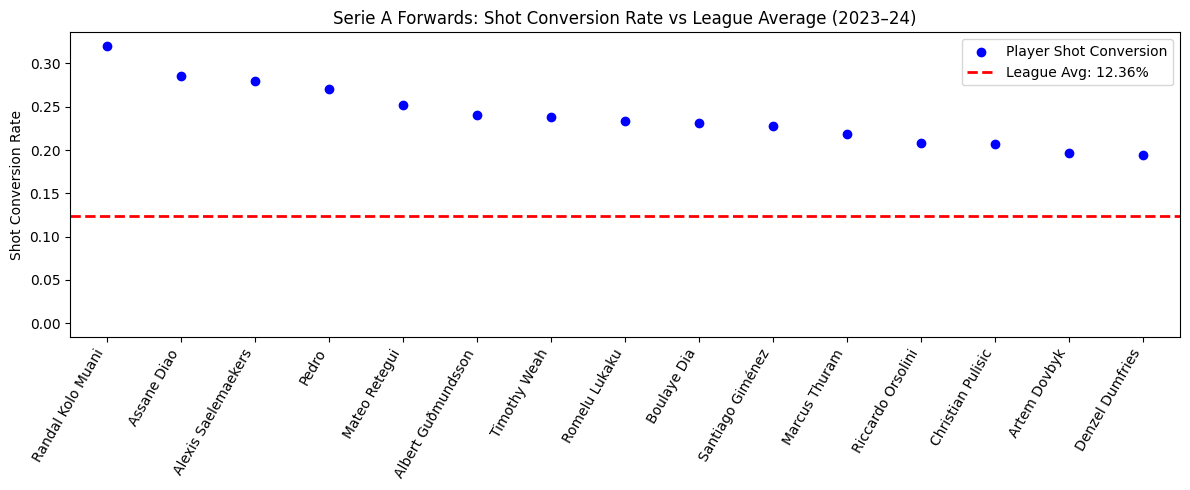

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate league average shot conversion (for forwards with min 20 shots)
league_avg = df_top_conversion['Shot_Conversion'].mean()

# Sort players for nice display
sorted_df = df_top_conversion.sort_values('Shot_Conversion', ascending=False)

plt.figure(figsize=(12, 5))
plt.scatter(
    range(len(sorted_df)),
    sorted_df['Shot_Conversion'],
    color='blue',
    label='Player Shot Conversion'
)
plt.axhline(league_avg, color='red', linestyle='--', linewidth=2, label=f'League Avg: {league_avg:.2%}')

# Optional: show player names on x-axis for top N
topN = 15
plt.xticks(
    ticks=range(topN),
    labels=sorted_df['Player'].head(topN),
    rotation=60,
    ha='right'
)
plt.xlim(-0.5, topN - 0.5)

plt.ylabel('Shot Conversion Rate')
plt.title('Serie A Forwards: Shot Conversion Rate vs League Average (2023–24)')
plt.legend()
plt.tight_layout()
plt.show()


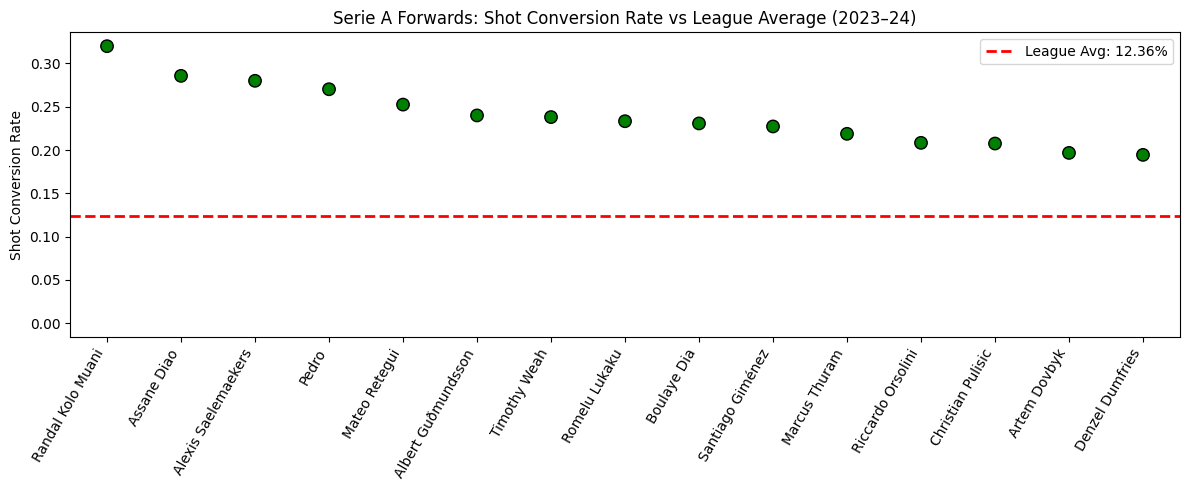

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate league average shot conversion for forwards with min 20 shots
league_avg = df_top_conversion['Shot_Conversion'].mean()

# Sort players for plotting
sorted_df = df_top_conversion.sort_values('Shot_Conversion', ascending=False).reset_index(drop=True)

# Assign colors: green if above or equal to average, orange if below
colors = np.where(sorted_df['Shot_Conversion'] >= league_avg, 'green', 'orange')

# Plot
plt.figure(figsize=(12, 5))
plt.scatter(
    range(len(sorted_df)),
    sorted_df['Shot_Conversion'],
    c=colors,
    s=80,
    edgecolor='k'
)
plt.axhline(league_avg, color='red', linestyle='--', linewidth=2, label=f'League Avg: {league_avg:.2%}')

# Optionally, label top N players on the x-axis
topN = 15
plt.xticks(
    ticks=range(topN),
    labels=sorted_df['Player'].head(topN),
    rotation=60,
    ha='right'
)
plt.xlim(-0.5, topN - 0.5)

plt.ylabel('Shot Conversion Rate')
plt.title('Serie A Forwards: Shot Conversion Rate vs League Average (2023–24)')
plt.legend()
plt.tight_layout()
plt.show()


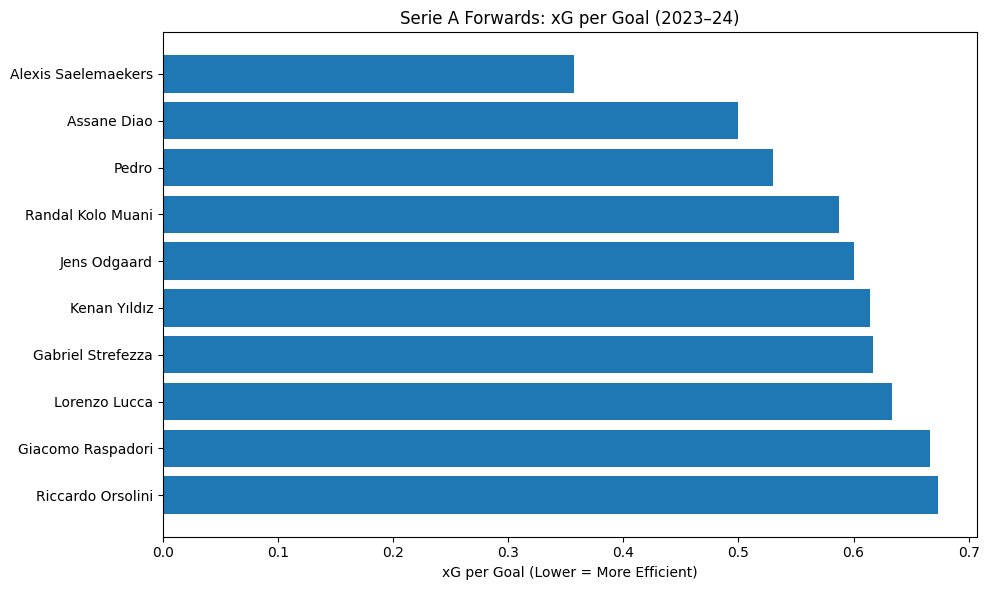

In [20]:
# Assuming 'Goals' and 'xG' columns exist
df_top_conversion['xG_per_Goal'] = df_top_conversion['xG'] / df_top_conversion['Goals']

# Visualize: Lower is better
plt.figure(figsize=(10,6))
plt.barh(
    df_top_conversion.sort_values('xG_per_Goal').head(10)['Player'][::-1],
    df_top_conversion.sort_values('xG_per_Goal').head(10)['xG_per_Goal'][::-1]
)
plt.xlabel('xG per Goal (Lower = More Efficient)')
plt.title('Serie A Forwards: xG per Goal (2023–24)')
plt.tight_layout()
plt.show()


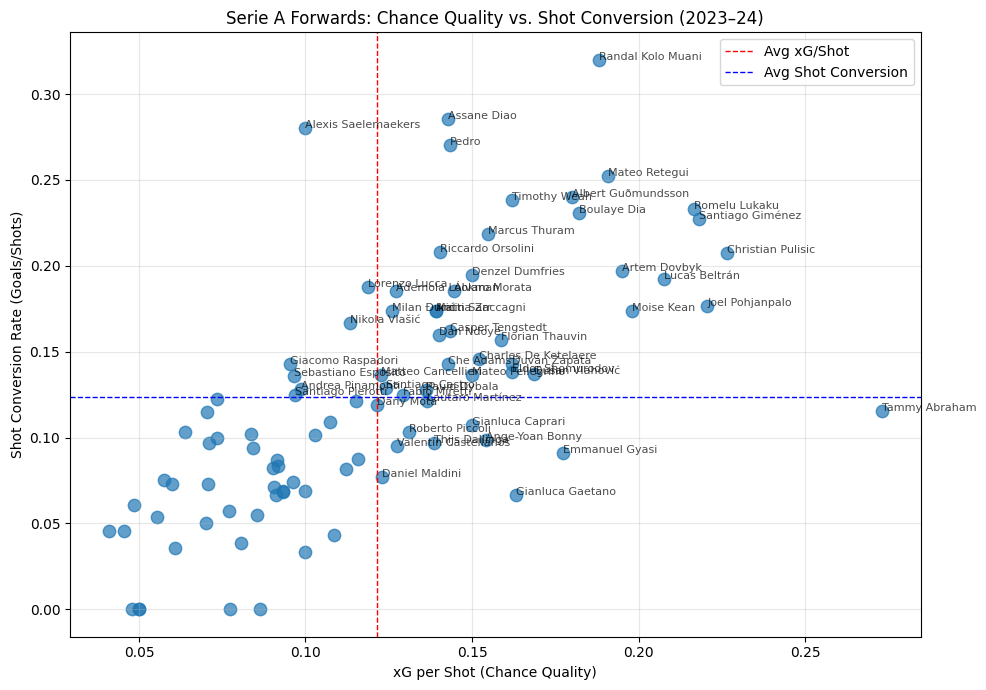

In [21]:
import matplotlib.pyplot as plt

# Calculate xG per shot (chance quality)
df_top_conversion['xG_per_shot'] = df_top_conversion['xG'] / df_top_conversion['Shots']

plt.figure(figsize=(10, 7))
plt.scatter(df_top_conversion['xG_per_shot'], df_top_conversion['Shot_Conversion'], s=80, alpha=0.7)

# Highlight player names for those in the "corners" (optional: tune thresholds)
for i, row in df_top_conversion.iterrows():
    if (
        (row['xG_per_shot'] > df_top_conversion['xG_per_shot'].mean() and row['Shot_Conversion'] > df_top_conversion['Shot_Conversion'].mean())
        or (row['xG_per_shot'] > df_top_conversion['xG_per_shot'].mean() and row['Shot_Conversion'] < df_top_conversion['Shot_Conversion'].mean())
        or (row['xG_per_shot'] < df_top_conversion['xG_per_shot'].mean() and row['Shot_Conversion'] > df_top_conversion['Shot_Conversion'].mean())
    ):
        plt.text(row['xG_per_shot'], row['Shot_Conversion'], row['Player'], fontsize=8, alpha=0.7)

plt.axvline(df_top_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_top_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Chance Quality vs. Shot Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
# Determine average
mean_xg_shot = df_top_conversion['xG_per_shot'].mean()
mean_conv = df_top_conversion['Shot_Conversion'].mean()

def finishing_group(row):
    if row['xG_per_shot'] >= mean_xg_shot and row['Shot_Conversion'] >= mean_conv:
        return 'Elite: Great Chances & Finishing'
    elif row['xG_per_shot'] >= mean_xg_shot:
        return 'Wasteful: Great Chances, Poor Finishing'
    elif row['Shot_Conversion'] >= mean_conv:
        return 'Clinical: Poor Chances, Great Finishing'
    else:
        return 'Ineffective: Poor Chances & Finishing'

df_top_conversion['Finishing_Type'] = df_top_conversion.apply(finishing_group, axis=1)


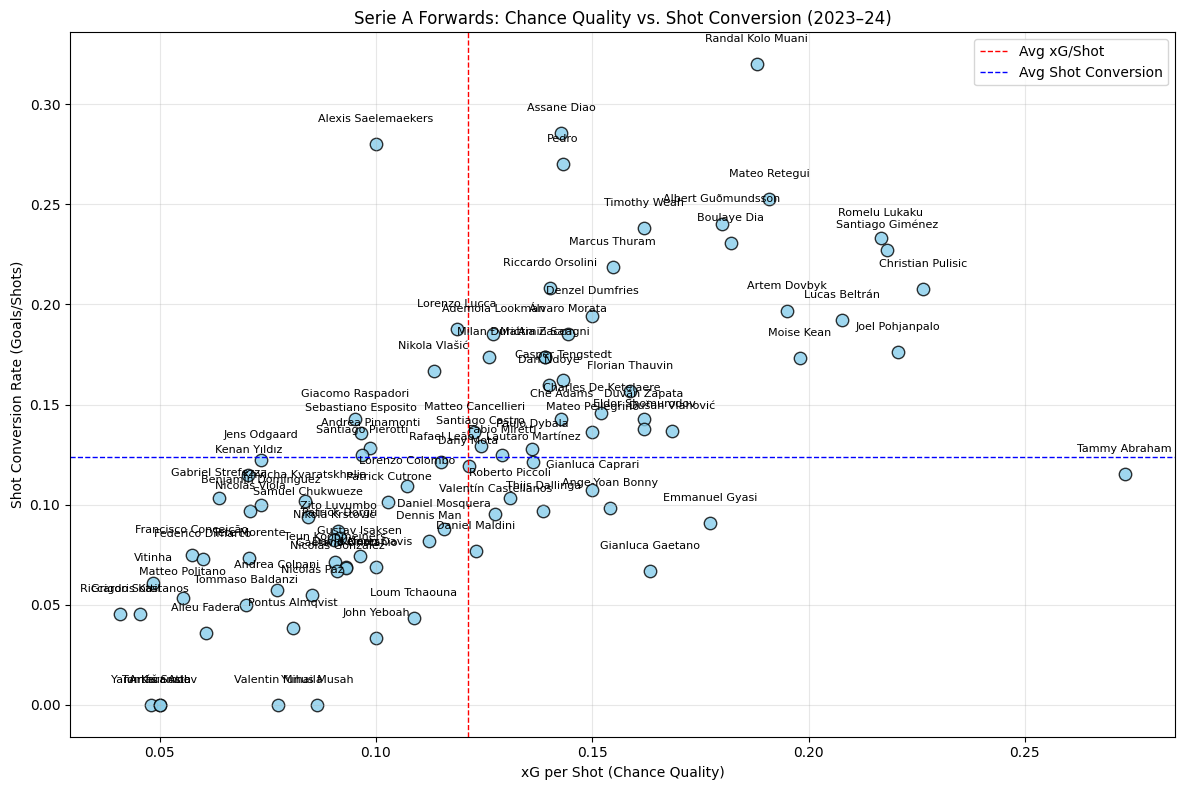

In [23]:
import matplotlib.pyplot as plt

# Calculate xG per shot
df_top_conversion['xG_per_shot'] = df_top_conversion['xG'] / df_top_conversion['Shots']

plt.figure(figsize=(12, 8))
plt.scatter(df_top_conversion['xG_per_shot'], df_top_conversion['Shot_Conversion'], s=80, alpha=0.8, color='skyblue', edgecolor='k')

# Annotate every player slightly above their dot
for i, row in df_top_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.01,  # vertical offset, tweak as needed
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

# Add average lines
plt.axvline(df_top_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_top_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Chance Quality vs. Shot Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


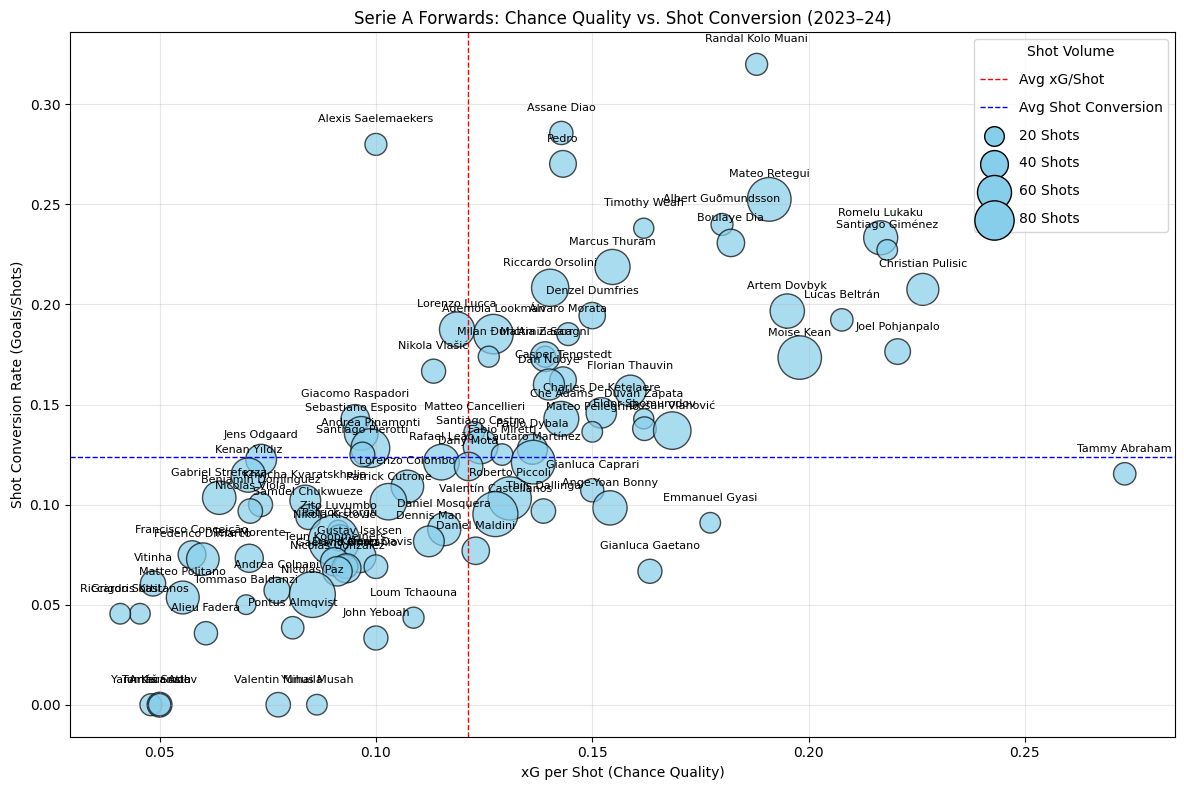

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate xG per shot if not already present
df_top_conversion['xG_per_shot'] = df_top_conversion['xG'] / df_top_conversion['Shots']

plt.figure(figsize=(12, 8))

# Scale shot volume for better visibility in plot (adjust 10 as needed)
sizes = df_top_conversion['Shots'].fillna(0) * 10

scatter = plt.scatter(
    df_top_conversion['xG_per_shot'],
    df_top_conversion['Shot_Conversion'],
    s=sizes,
    alpha=0.7,
    c='skyblue',
    edgecolor='k'
)

# Annotate EVERY player above their dot
for i, row in df_top_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.01,
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

# Draw average lines
plt.axvline(df_top_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_top_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Chance Quality vs. Shot Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)

# Add shot volume legend
for shots in [20, 40, 60, 80]:
    plt.scatter([], [], s=shots*10, c='skyblue', edgecolor='k', label=f'{shots} Shots')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Shot Volume')

plt.tight_layout()
plt.show()


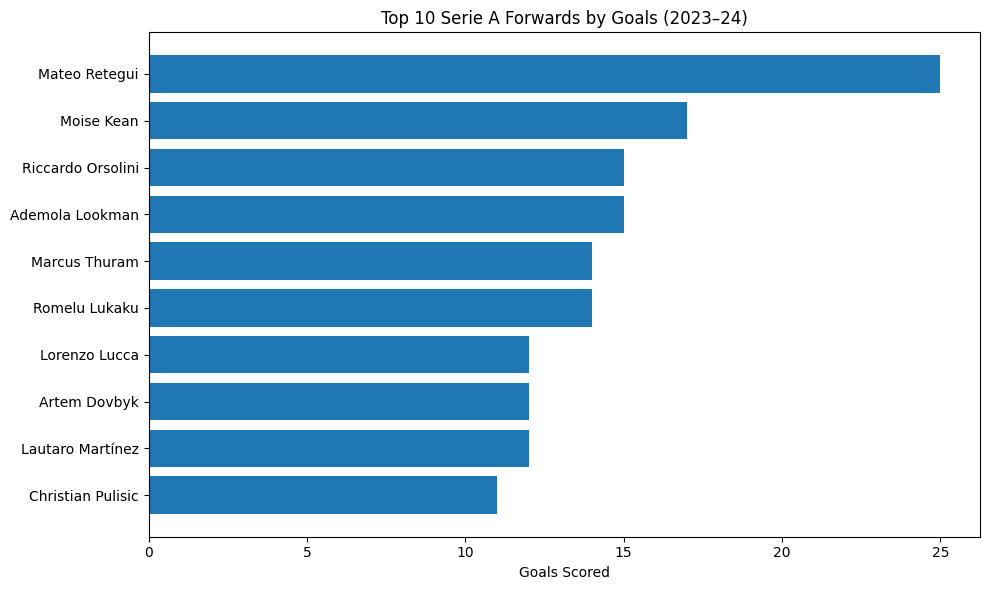

In [25]:
import matplotlib.pyplot as plt

# Sort by goals scored and select top N (e.g., top 10)
top_goal_scorers = df_top_conversion.sort_values('Goals', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    top_goal_scorers['Player'][::-1],   # Reverse for highest at top
    top_goal_scorers['Goals'][::-1]
)
plt.xlabel('Goals Scored')
plt.title('Top 10 Serie A Forwards by Goals (2023–24)')
plt.tight_layout()
plt.show()


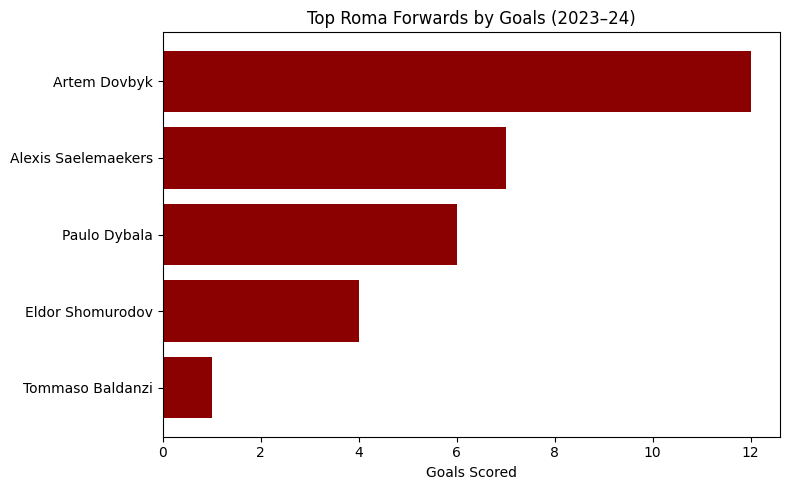

In [26]:
import matplotlib.pyplot as plt

# Filter for Roma players only
roma_forwards = df_top_conversion[df_top_conversion['Squad'] == 'Roma']

# Sort by goals and select top N (all, or top 5/10 if you prefer)
top_roma_scorers = roma_forwards.sort_values('Goals', ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.barh(
    top_roma_scorers['Player'][::-1],
    top_roma_scorers['Goals'][::-1],
    color='darkred'
)
plt.xlabel('Goals Scored')
plt.title('Top Roma Forwards by Goals (2023–24)')
plt.tight_layout()
plt.show()


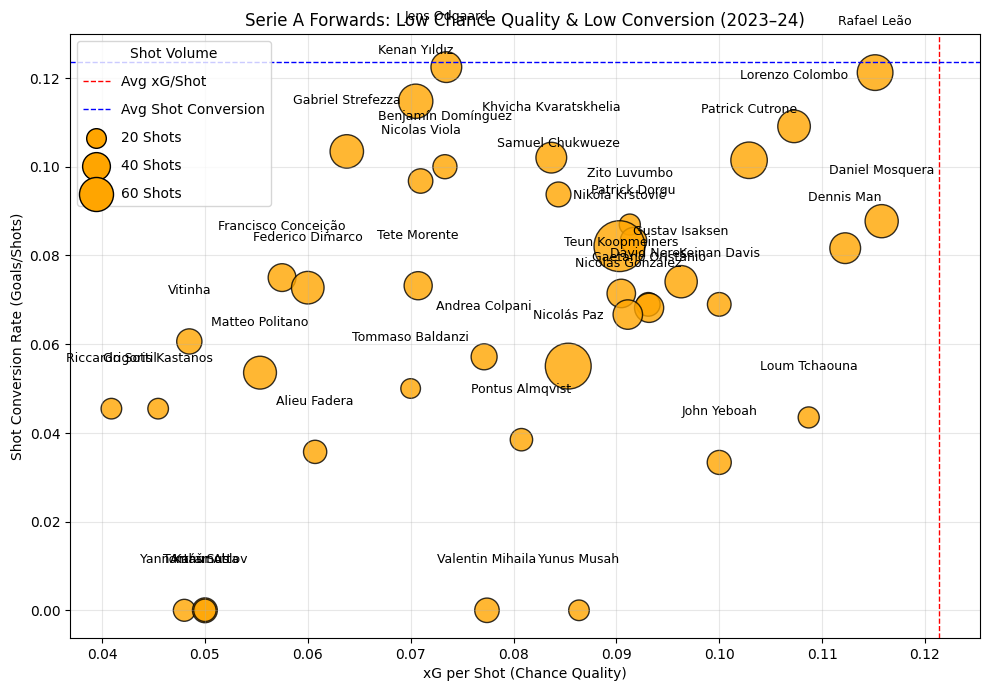

                    Player          Squad  Shots  xG_per_shot  Shot_Conversion
106        Nikola Krstović          Lecce    134     0.090299         0.082090
152            Nicolás Paz           Como    109     0.085321         0.055046
47         Patrick Cutrone           Como     69     0.102899         0.101449
111            Rafael Leão          Milan     66     0.115152         0.121212
202           Kenan Yıldız       Juventus     61     0.070492         0.114754
185      Gabriel Strefezza           Como     58     0.063793         0.103448
133        Daniel Mosquera  Hellas Verona     57     0.115789         0.087719
164        Matteo Politano         Napoli     56     0.055357         0.053571
41         Lorenzo Colombo         Empoli     55     0.107273         0.109091
55        Federico Dimarco          Inter     55     0.060000         0.072727
90          Gustav Isaksen          Lazio     54     0.096296         0.074074
144           Jens Odgaard        Bologna     49    

In [27]:
import matplotlib.pyplot as plt

# Calculate averages
mean_xg_per_shot = df_top_conversion['xG_per_shot'].mean()
mean_conversion = df_top_conversion['Shot_Conversion'].mean()

# Filter: Bottom left = below average for both metrics
bottom_left = df_top_conversion[
    (df_top_conversion['xG_per_shot'] < mean_xg_per_shot) &
    (df_top_conversion['Shot_Conversion'] < mean_conversion)
]

# Visualize only these players
plt.figure(figsize=(10, 7))

sizes = bottom_left['Shots'].fillna(0) * 10

plt.scatter(
    bottom_left['xG_per_shot'],
    bottom_left['Shot_Conversion'],
    s=sizes,
    alpha=0.8,
    c='orange',
    edgecolor='k'
)

for i, row in bottom_left.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.01,
        row['Player'],
        fontsize=9,
        ha='center',
        va='bottom'
    )

plt.axvline(mean_xg_per_shot, color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(mean_conversion, color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Low Chance Quality & Low Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)

# Add shot volume legend
for shots in [20, 40, 60]:
    plt.scatter([], [], s=shots*10, c='orange', edgecolor='k', label=f'{shots} Shots')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Shot Volume')

plt.tight_layout()
plt.show()

# Optionally, print these players for review
print(bottom_left[['Player', 'Squad', 'Shots', 'xG_per_shot', 'Shot_Conversion']].sort_values('Shots', ascending=False))


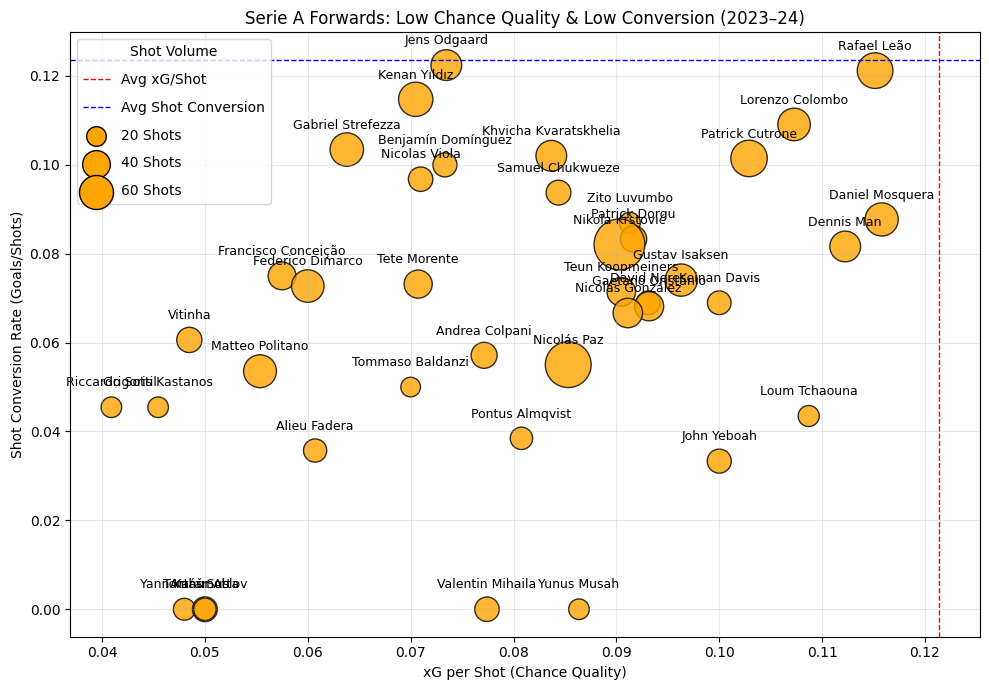

In [28]:
import matplotlib.pyplot as plt

# Calculate averages
mean_xg_per_shot = df_top_conversion['xG_per_shot'].mean()
mean_conversion = df_top_conversion['Shot_Conversion'].mean()

# Filter for bottom left quadrant
bottom_left = df_top_conversion[
    (df_top_conversion['xG_per_shot'] < mean_xg_per_shot) &
    (df_top_conversion['Shot_Conversion'] < mean_conversion)
]

plt.figure(figsize=(10, 7))
sizes = bottom_left['Shots'].fillna(0) * 10

plt.scatter(
    bottom_left['xG_per_shot'],
    bottom_left['Shot_Conversion'],
    s=sizes,
    alpha=0.8,
    c='orange',
    edgecolor='k'
)

for i, row in bottom_left.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.004,   # <--- smaller offset
        row['Player'],
        fontsize=9,
        ha='center',
        va='bottom'
    )

plt.axvline(mean_xg_per_shot, color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(mean_conversion, color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')

plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Forwards: Low Chance Quality & Low Conversion (2023–24)')
plt.legend()
plt.grid(alpha=0.3)

# Add shot volume legend
for shots in [20, 40, 60]:
    plt.scatter([], [], s=shots*10, c='orange', edgecolor='k', label=f'{shots} Shots')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Shot Volume')

plt.tight_layout()
plt.show()


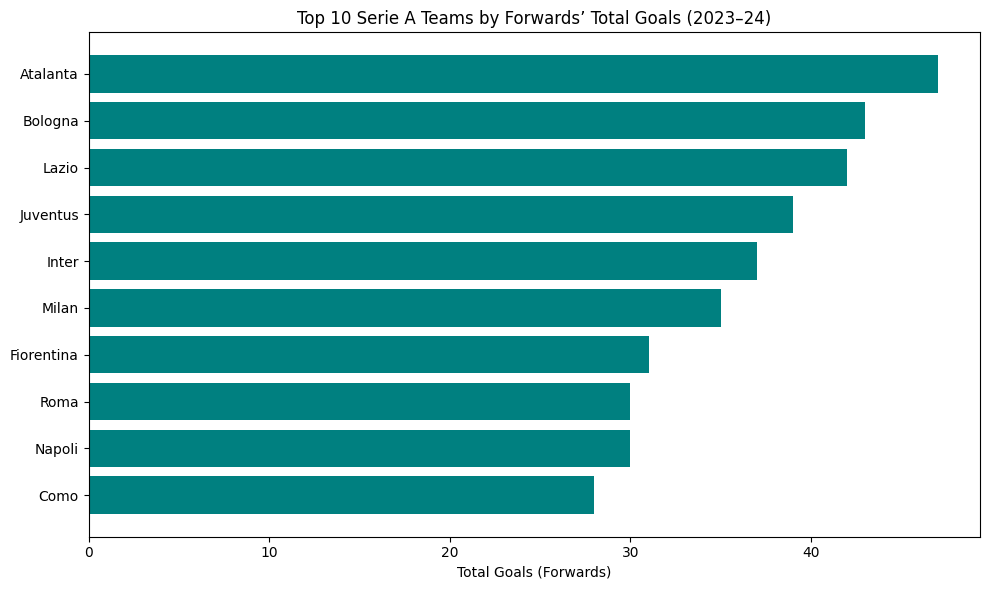

In [29]:
import matplotlib.pyplot as plt

# Group by team, sum goals
team_goals = (
    df_top_conversion.groupby('Squad')['Goals'].sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
plt.barh(team_goals.index[::-1], team_goals.values[::-1], color='teal')
plt.xlabel('Total Goals (Forwards)')
plt.title('Top 10 Serie A Teams by Forwards’ Total Goals (2023–24)')
plt.tight_layout()
plt.show()


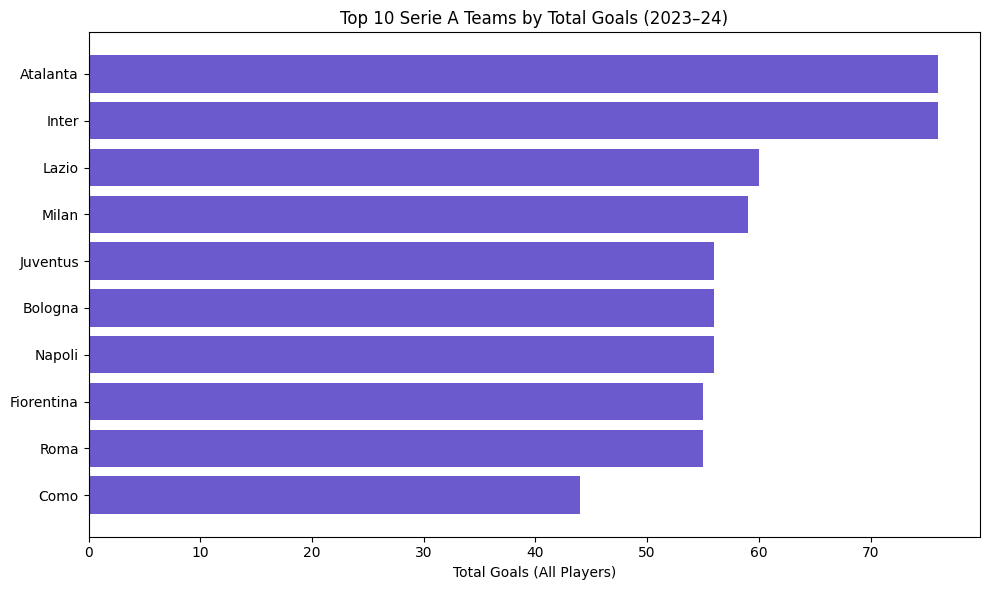

In [30]:
import matplotlib.pyplot as plt

# Make sure 'Performance_Gls' is numeric
df_std['Performance_Gls'] = pd.to_numeric(df_std['Performance_Gls'], errors='coerce')

# Group by squad, sum goals
team_goals_all = (
    df_std.groupby('Squad')['Performance_Gls'].sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
plt.barh(team_goals_all.index[::-1], team_goals_all.values[::-1], color='slateblue')
plt.xlabel('Total Goals (All Players)')
plt.title('Top 10 Serie A Teams by Total Goals (2023–24)')
plt.tight_layout()
plt.show()


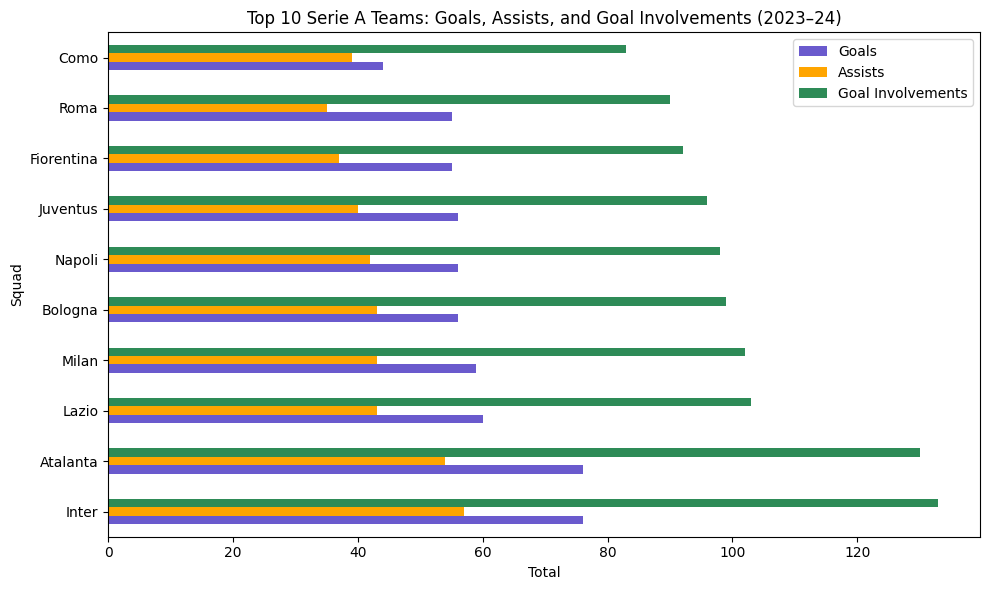

In [31]:
# Make sure assists are numeric
df_std['Performance_Ast'] = pd.to_numeric(df_std['Performance_Ast'], errors='coerce')
df_std['Performance_Gls'] = pd.to_numeric(df_std['Performance_Gls'], errors='coerce')

# Total goal involvements per team
team_involvement = (
    df_std.groupby('Squad').apply(
        lambda x: pd.Series({
            'Goals': x['Performance_Gls'].sum(),
            'Assists': x['Performance_Ast'].sum(),
            'Goal Involvements': x['Performance_Gls'].sum() + x['Performance_Ast'].sum()
        })
    )
    .sort_values('Goal Involvements', ascending=False)
    .head(10)
)

team_involvement[['Goals', 'Assists', 'Goal Involvements']].plot(
    kind='barh', figsize=(10,6), color=['slateblue', 'orange', 'seagreen']
)
plt.xlabel('Total')
plt.title('Top 10 Serie A Teams: Goals, Assists, and Goal Involvements (2023–24)')
plt.tight_layout()
plt.show()


                     Top Scorer  Total Goals  Top Scorer Goals  Top Scorer %
Squad                                                                       
Lecce           Nikola Krstović           27                11      0.407407
Atalanta          Mateo Retegui           76                25      0.328947
Fiorentina           Moise Kean           55                17      0.309091
Udinese           Lorenzo Lucca           41                12      0.292683
Genoa          Andrea Pinamonti           35                10      0.285714
Bologna       Riccardo Orsolini           56                15      0.267857
Cagliari        Roberto Piccoli           38                10      0.263158
Empoli      Sebastiano Esposito           31                 8      0.258065
Torino                Che Adams           36                 9      0.250000
Napoli            Romelu Lukaku           56                14      0.250000


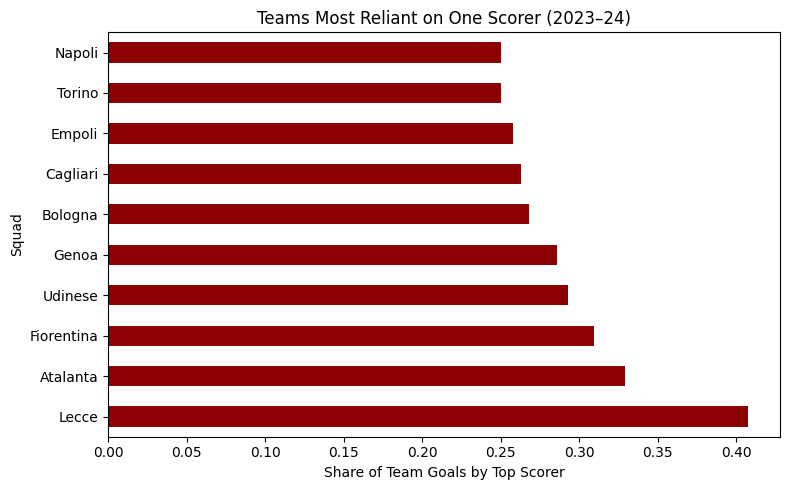

In [32]:
# For each team, find top scorer and their share
top_scorer_share = (
    df_std.groupby('Squad').apply(
        lambda x: pd.Series({
            'Total Goals': x['Performance_Gls'].sum(),
            'Top Scorer': x.loc[x['Performance_Gls'].idxmax(), 'Player'],
            'Top Scorer Goals': x['Performance_Gls'].max()
        })
    )
)
top_scorer_share['Top Scorer %'] = top_scorer_share['Top Scorer Goals'] / top_scorer_share['Total Goals']

# Show top 10 by top scorer share
top10_share = top_scorer_share.sort_values('Top Scorer %', ascending=False).head(10)
print(top10_share[['Top Scorer', 'Total Goals', 'Top Scorer Goals', 'Top Scorer %']])

top10_share['Top Scorer %'].plot(kind='barh', figsize=(8,5), color='darkred')
plt.xlabel('Share of Team Goals by Top Scorer')
plt.title('Teams Most Reliant on One Scorer (2023–24)')
plt.tight_layout()
plt.show()


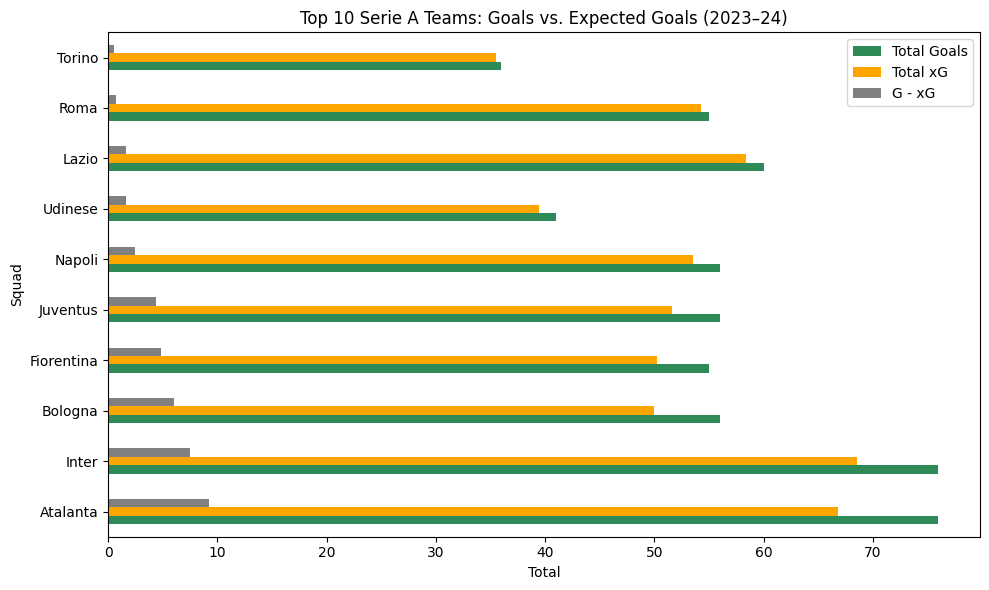

In [33]:
df_std['Expected_xG'] = pd.to_numeric(df_std['Expected_xG'], errors='coerce')
team_xg_performance = (
    df_std.groupby('Squad').apply(
        lambda x: pd.Series({
            'Total Goals': x['Performance_Gls'].sum(),
            'Total xG': x['Expected_xG'].sum(),
            'G - xG': x['Performance_Gls'].sum() - x['Expected_xG'].sum()
        })
    )
    .sort_values('G - xG', ascending=False)
    .head(10)
)
team_xg_performance[['Total Goals', 'Total xG', 'G - xG']].plot(
    kind='barh', figsize=(10,6), color=['seagreen', 'orange', 'gray']
)
plt.xlabel('Total')
plt.title('Top 10 Serie A Teams: Goals vs. Expected Goals (2023–24)')
plt.tight_layout()
plt.show()


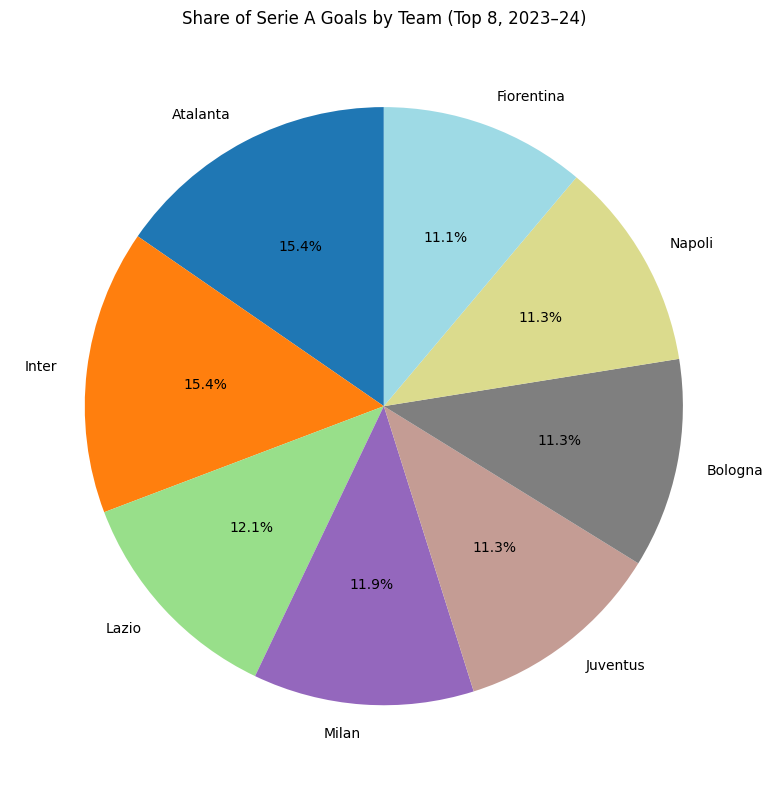

In [34]:
# Get total goals by team for all players
goals_by_team = (
    df_std.groupby('Squad')['Performance_Gls'].sum()
    .sort_values(ascending=False)
)
plt.figure(figsize=(8,8))
goals_by_team.head(8).plot(
    kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20', legend=False
)
plt.ylabel('')
plt.title('Share of Serie A Goals by Team (Top 8, 2023–24)')
plt.tight_layout()
plt.show()


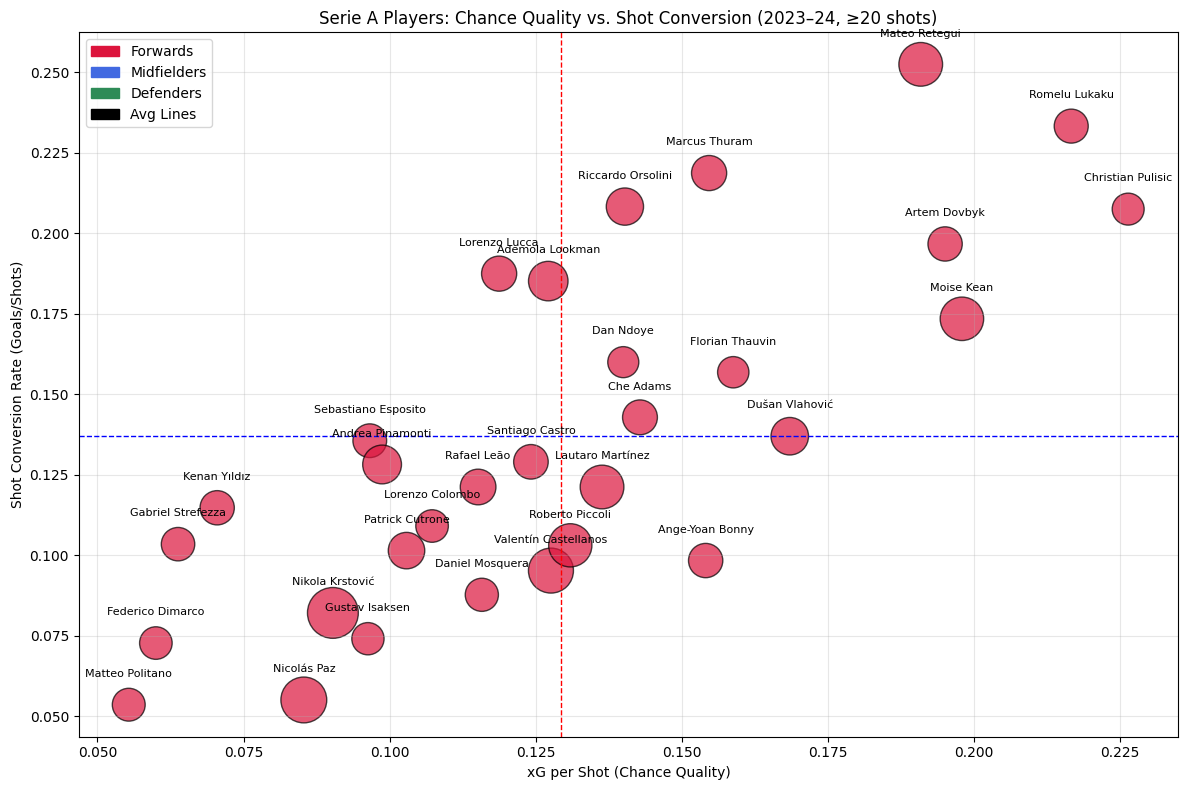

In [46]:
# Instead of filtering by forwards, include all players with at least 20 shots
df_all_conversion = df_merged[df_merged['Shots'] >= 50].copy()
df_all_conversion['xG'] = pd.to_numeric(df_all_conversion['Expected_xG'], errors='coerce')
df_all_conversion['xG_per_shot'] = df_all_conversion['xG'] / df_all_conversion['Shots']


# Plot chance quality vs. conversion, colored by position group
position_colors = df_all_conversion['Pos'].apply(
    lambda pos: 'crimson' if 'FW' in pos else ('royalblue' if 'MF' in pos else 'seagreen')
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(
    df_all_conversion['xG_per_shot'],
    df_all_conversion['Shot_Conversion'],
    s=df_all_conversion['Shots']*10,
    alpha=0.7,
    c=position_colors,
    edgecolor='k'
)
for i, row in df_all_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.008,
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )
plt.axvline(df_all_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_all_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Players: Chance Quality vs. Shot Conversion (2023–24, ≥20 shots)')
from matplotlib.patches import Patch
plt.legend(handles=[
    Patch(color='crimson', label='Forwards'),
    Patch(color='royalblue', label='Midfielders'),
    Patch(color='seagreen', label='Defenders'),
    Patch(color='black', label='Avg Lines')
])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


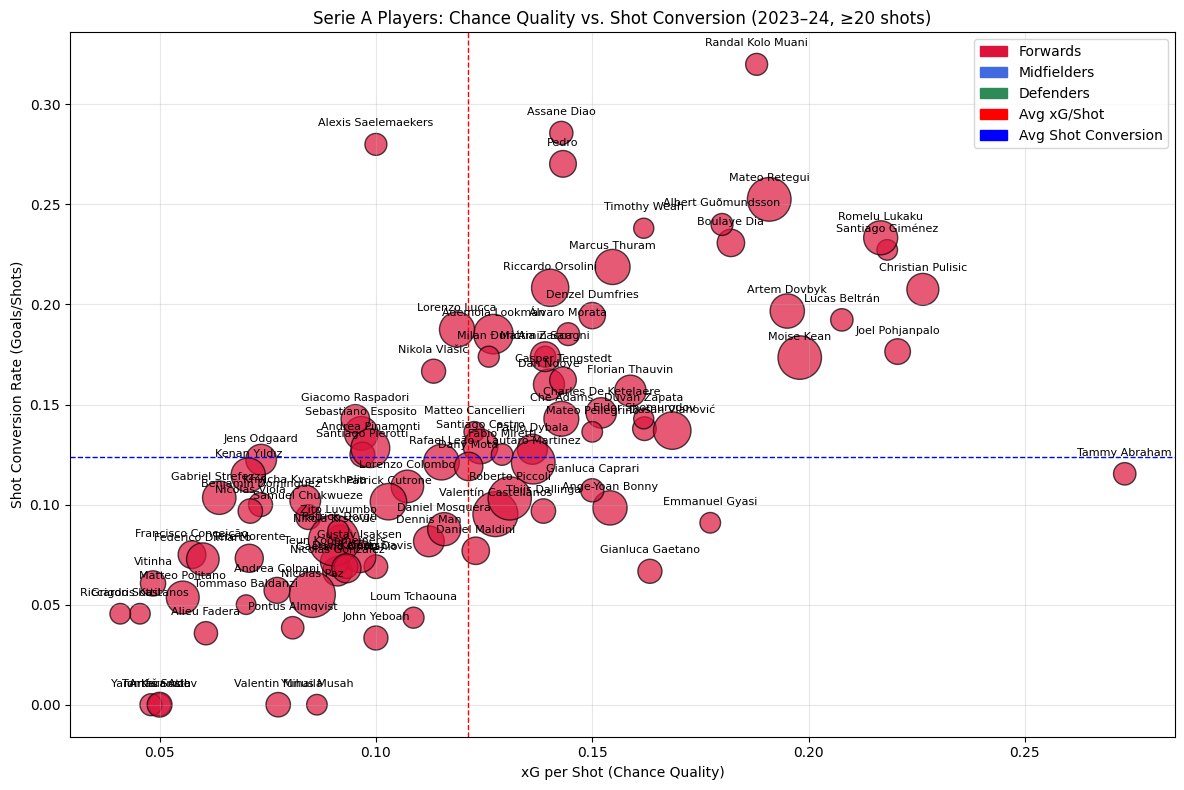

In [47]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd

# 1. Filter for players with at least 20 shots
df_all_conversion = df_merged[df_merged['Shots'] >= 20].copy()

# 2. Use the correct xG column
df_all_conversion['xG'] = pd.to_numeric(df_all_conversion['Expected_xG'], errors='coerce')
df_all_conversion['xG_per_shot'] = df_all_conversion['xG'] / df_all_conversion['Shots']

# 3. Color by position
def position_color(pos):
    if pd.isna(pos):
        return 'gray'
    if 'FW' in pos:
        return 'crimson'
    elif 'MF' in pos:
        return 'royalblue'
    else:
        return 'seagreen'
position_colors = df_all_conversion['Pos'].apply(position_color)

# 4. Plot
plt.figure(figsize=(12,8))
plt.scatter(
    df_all_conversion['xG_per_shot'],
    df_all_conversion['Shot_Conversion'],
    s=df_all_conversion['Shots']*10,
    alpha=0.7,
    c=position_colors,
    edgecolor='k'
)
for i, row in df_all_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.008,
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )
plt.axvline(df_all_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_all_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Players: Chance Quality vs. Shot Conversion (2023–24, ≥20 shots)')

# Custom legend for positions and avg lines
plt.legend(handles=[
    Patch(color='crimson', label='Forwards'),
    Patch(color='royalblue', label='Midfielders'),
    Patch(color='seagreen', label='Defenders'),
    Patch(color='red', label='Avg xG/Shot'),
    Patch(color='blue', label='Avg Shot Conversion')
])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


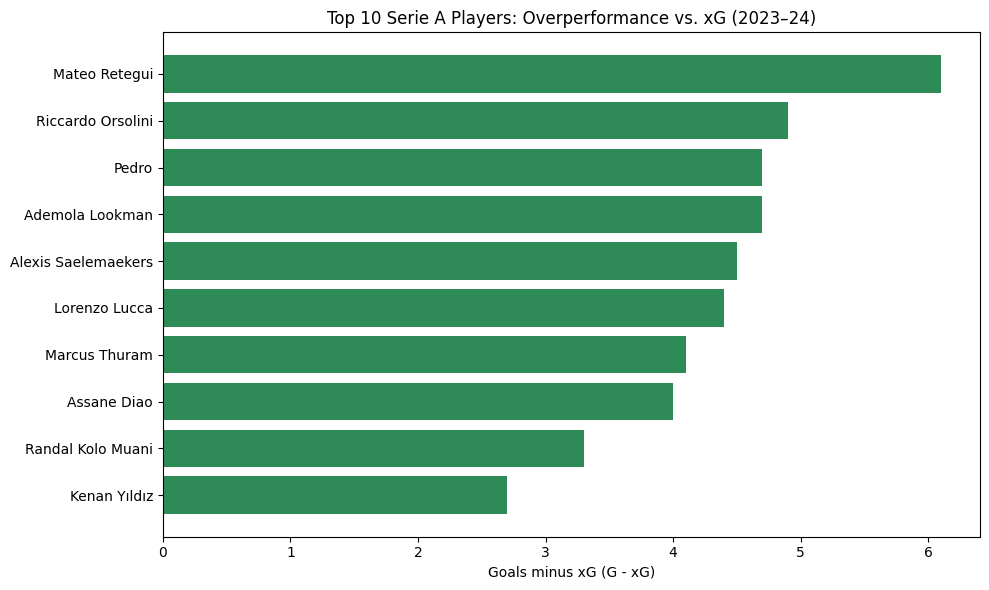

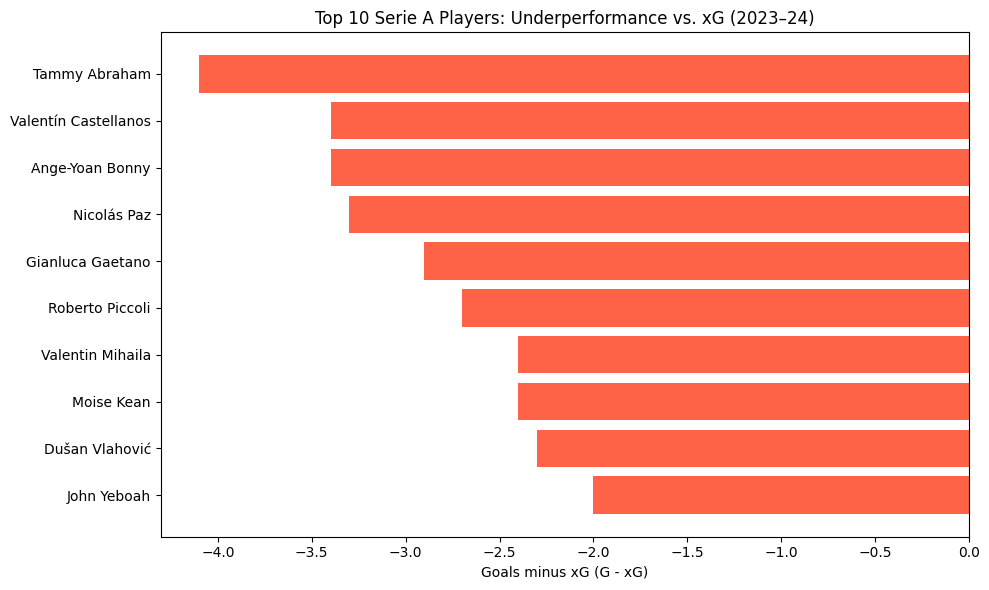

In [48]:
import matplotlib.pyplot as plt

# Use your all players dataframe (not just forwards!)
df_all_conversion['G_minus_xG'] = df_all_conversion['Goals'] - df_all_conversion['xG']

# Top 10 overperformers
top_over = df_all_conversion.sort_values('G_minus_xG', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(
    top_over['Player'][::-1],
    top_over['G_minus_xG'][::-1],
    color='seagreen'
)
plt.xlabel('Goals minus xG (G - xG)')
plt.title('Top 10 Serie A Players: Overperformance vs. xG (2023–24)')
plt.tight_layout()
plt.show()

# Top 10 underperformers (lowest G-xG)
top_under = df_all_conversion.sort_values('G_minus_xG').head(10)

plt.figure(figsize=(10,6))
plt.barh(
    top_under['Player'][::-1],
    top_under['G_minus_xG'][::-1],
    color='tomato'
)
plt.xlabel('Goals minus xG (G - xG)')
plt.title('Top 10 Serie A Players: Underperformance vs. xG (2023–24)')
plt.tight_layout()
plt.show()


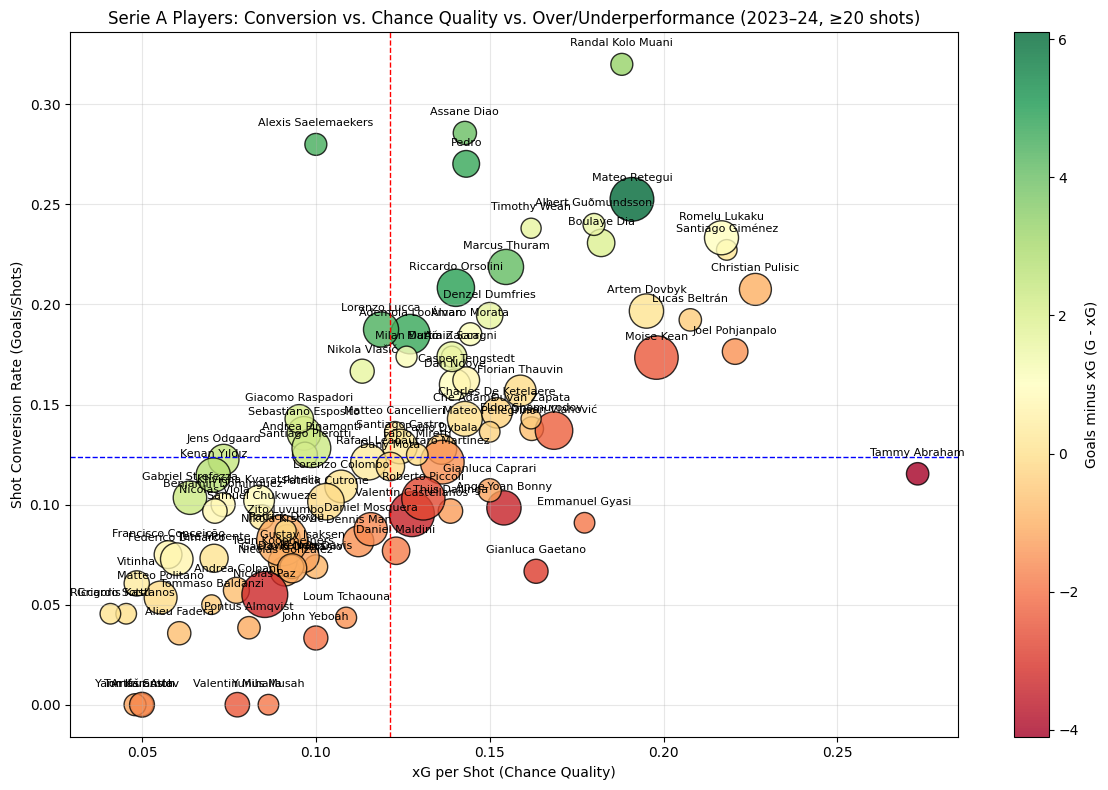

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the relevant columns exist and are numeric
df_all_conversion['xG'] = pd.to_numeric(df_all_conversion['Expected_xG'], errors='coerce')
df_all_conversion['G_minus_xG'] = df_all_conversion['Goals'] - df_all_conversion['xG']
df_all_conversion['xG_per_shot'] = df_all_conversion['xG'] / df_all_conversion['Shots']

plt.figure(figsize=(12,8))

# Use a diverging colormap for over/underperformance
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(df_all_conversion['G_minus_xG'].min(), df_all_conversion['G_minus_xG'].max())

# Scatter plot: color by G - xG
sc = plt.scatter(
    df_all_conversion['xG_per_shot'],
    df_all_conversion['Shot_Conversion'],
    s=df_all_conversion['Shots']*10,
    c=df_all_conversion['G_minus_xG'],
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    edgecolor='k'
)

# Annotate
for i, row in df_all_conversion.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.008,
        row['Player'],
        fontsize=8,
        ha='center',
        va='bottom'
    )

plt.axvline(df_all_conversion['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_all_conversion['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A Players: Conversion vs. Chance Quality vs. Over/Underperformance (2023–24, ≥20 shots)')

cbar = plt.colorbar(sc)
cbar.set_label('Goals minus xG (G - xG)')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


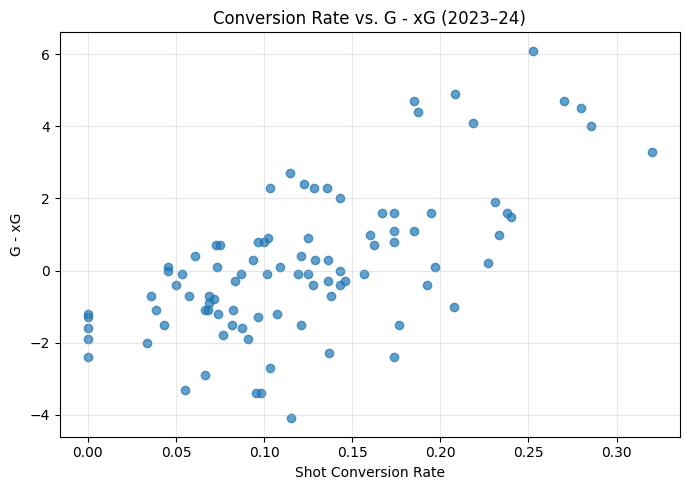

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(df_all_conversion['Shot_Conversion'], df_all_conversion['G_minus_xG'], alpha=0.7)
plt.xlabel('Shot Conversion Rate')
plt.ylabel('G - xG')
plt.title('Conversion Rate vs. G - xG (2023–24)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [121]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

url = "https://fbref.com/en/comps/11/wages/Serie-A-Wages"
res = requests.get(url)
soup = BeautifulSoup(res.text, "lxml")

# Find the first table on the page (player wages)
# Find all tables
tables = soup.find_all("table")


In [155]:
for i, table in enumerate(tables):
    print(f"\nTable {i}")
    df = pd.read_html(str(table))[0]
    print(df.columns)
    print(df.head(2))
    squad_tag = table.find_previous(['h2', 'h3'])
    print("Squad tag:", squad_tag.text if squad_tag else None)



Table 0
Index(['Rk', 'Squad', '# Pl', 'Weekly Wages', 'Annual Wages', '% Estimated'], dtype='object')
   Rk     Squad  # Pl                           Weekly Wages  \
0   1     Inter    52  € 2,778,846 (£ 2,345,112, $3,148,093)   
1   2  Juventus    55  € 2,146,769 (£ 1,811,693, $2,432,027)   

                                  Annual Wages % Estimated  
0  € 144,500,000 (£ 121,945,841, $163,700,814)          4%  
1   € 111,632,000 (£ 94,208,015, $126,465,393)          6%  
Squad tag: Squad Wages

Table 1
Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Weekly Wages',
       'Annual Wages', 'Notes'],
      dtype='object')
   Rk            Player  Nation Pos     Squad  Age  \
0   1    Dušan Vlahović  rs SRB  FW  Juventus   24   
1   2  Lautaro Martínez  ar ARG  FW     Inter   26   

                      Weekly Wages                              Annual Wages  \
0  € 427,308 (£ 360,680, $440,482)  € 22,220,000 (£ 18,755,376, $22,905,045)   
1  € 320,577 (£ 270,591, $330,460)  € 1

In [157]:
player_salaries = []
for idx in range(1, len(tables), 1):  # player tables at odd indices
    df = pd.read_html(str(table))[0]
    player_salaries.append(df)

df_players = pd.concat(player_salaries, ignore_index=True)
print(df_players[['Player', 'Squad']].head(10))


               Player     Squad
0      Dušan Vlahović  Juventus
1    Lautaro Martínez     Inter
2      Nicolò Barella     Inter
3    Hakan Çalhanoğlu     Inter
4  Alessandro Bastoni     Inter
5      Gleison Bremer  Juventus
6     Piotr Zieliński     Inter
7       Álvaro Morata     Milan
8        Douglas Luiz  Juventus
9       Marcus Thuram     Inter


In [159]:
# Example cleaning for GBP or USD
import re
def extract_usd_amount(wage_str):
    match = re.search(r'\$([\d,]+)', str(wage_str))
    if match:
        return float(match.group(1).replace(',', ''))
    return None

df_players['Annual_Wages_USD'] = df_players['Annual Wages'].astype(str).apply(extract_usd_amount)
df_players['Salary_M_USD'] = df_players['Annual_Wages_USD'] / 1_000_000

# Standardize names
df_players['Player'] = df_players['Player'].str.lower().str.strip()
df_players['Squad'] = df_players['Squad'].str.lower().str.strip()
df_all_conversion['Player'] = df_all_conversion['Player'].str.lower().str.strip()
df_all_conversion['Squad'] = df_all_conversion['Squad'].str.lower().str.strip()

# Merge!
df_stats_salary = pd.merge(
    df_all_conversion,
    df_players[['Player', 'Squad', 'Salary_M_USD']],
    on=['Player', 'Squad'],
    how='left'
)


In [160]:
import re
import pandas as pd

# Extract USD salary (if you haven't already)
def extract_usd_amount(wage_str):
    match = re.search(r'\$([\d,]+)', str(wage_str))
    if match:
        return float(match.group(1).replace(',', ''))
    return None

df_players['Annual_Wages_USD'] = df_players['Annual Wages'].astype(str).apply(extract_usd_amount)
df_players['Salary_M_USD'] = df_players['Annual_Wages_USD'] / 1_000_000

# Standardize for merge
df_players['Player'] = df_players['Player'].str.lower().str.strip()
df_players['Squad'] = df_players['Squad'].str.lower().str.strip()
df_all_conversion['Player'] = df_all_conversion['Player'].str.lower().str.strip()
df_all_conversion['Squad'] = df_all_conversion['Squad'].str.lower().str.strip()


In [161]:
import unicodedata

def remove_accents(text):
    if pd.isnull(text):
        return ""
    return ''.join(
        c for c in unicodedata.normalize('NFKD', str(text))
        if not unicodedata.combining(c)
    )

df_players['Player'] = df_players['Player'].apply(remove_accents).str.lower().str.strip()
df_players['Squad'] = df_players['Squad'].apply(remove_accents).str.lower().str.strip()

# Do the same for your stats DataFrame:
df_all_conversion['Player'] = df_all_conversion['Player'].apply(remove_accents).str.lower().str.strip()
df_all_conversion['Squad'] = df_all_conversion['Squad'].apply(remove_accents).str.lower().str.strip()


In [163]:
df_stats_salary = pd.merge(
    df_all_conversion,
    df_players[['Player', 'Squad', 'Salary_M_USD']],
    on=['Player', 'Squad'],
    how='left'
)


In [165]:
# Make sure these columns are numeric
df_stats_salary['Goals'] = pd.to_numeric(df_stats_salary['Goals'], errors='coerce')
df_stats_salary['xG'] = pd.to_numeric(df_stats_salary['xG'], errors='coerce')
df_stats_salary['Salary_M_USD'] = pd.to_numeric(df_stats_salary['Salary_M_USD'], errors='coerce')

# Filter for players with salary data and at least 1 goal or xG
df_stats_salary = df_stats_salary[df_stats_salary['Salary_M_USD'] > 0]
df_stats_salary = df_stats_salary[df_stats_salary['Goals'].notnull() | df_stats_salary['xG'].notnull()]

# ROI and value metrics
df_stats_salary['Goals_per_Million'] = df_stats_salary['Goals'] / df_stats_salary['Salary_M_USD']
df_stats_salary['xG_per_Million'] = df_stats_salary['xG'] / df_stats_salary['Salary_M_USD']
df_stats_salary['G_minus_xG'] = df_stats_salary['Goals'] - df_stats_salary['xG']


In [166]:
print("Top ROI (Goals per $1M):")
print(
    df_stats_salary
    .sort_values('Goals_per_Million', ascending=False)
    [['Player', 'Squad', 'Goals', 'xG', 'Salary_M_USD', 'Goals_per_Million', 'G_minus_xG']]
    .head(15)
)

print("\nTop Overperformers (G-xG):")
print(
    df_stats_salary
    .sort_values('G_minus_xG', ascending=False)
    [['Player', 'Squad', 'Goals', 'xG', 'Salary_M_USD', 'G_minus_xG']]
    .head(10)
)


Top ROI (Goals per $1M):
                 Player          Squad  Goals    xG  Salary_M_USD  \
44        lorenzo lucca        udinese     12   7.6      0.474182   
40      nikola krstovic          lecce     11  12.1      0.463874   
65      roberto piccoli       cagliari     10  12.7      0.577265   
6       ange-yoan bonny          parma      6   9.4      0.556648   
80     casper tengstedt  hellas verona      6   5.3      0.556648   
15      patrick cutrone           como      7   7.1      0.659731   
27  sebastiano esposito         empoli      8   5.7      0.762814   
54      daniel mosquera  hellas verona      5   6.6      0.577265   
72        mateo retegui       atalanta     25  18.9      2.906941   
10      santiago castro        bologna      8   7.7      0.958672   
77    gabriel strefezza           como      6   3.7      0.762814   
20          assane diao           como      8   4.0      1.053576   
57            dan ndoye        bologna      8   7.0      1.061755   
66    san

In [169]:
# Lowercase and strip for matching
import unicodedata

def remove_accents(text):
    if pd.isnull(text):
        return ""
    return ''.join(
        c for c in unicodedata.normalize('NFKD', str(text))
        if not unicodedata.combining(c)
    )

for col in ['Player', 'Squad']:
    df_all_conversion[col] = df_all_conversion[col].apply(remove_accents).str.lower().str.strip()
    df_players[col] = df_players[col].apply(remove_accents).str.lower().str.strip()

df_all_conversion['xG'] = pd.to_numeric(df_all_conversion['Expected_xG'], errors='coerce')
df_all_conversion['G_minus_xG'] = df_all_conversion['Goals'] - df_all_conversion['xG']
df_all_conversion['xG_per_shot'] = df_all_conversion['xG'] / df_all_conversion['Shots']

# Merge on player+club
df_all_value = pd.merge(
    df_all_conversion,
    df_players[['Player', 'Squad', 'Salary_M_USD']],
    on=['Player', 'Squad'],
    how='left'
)


In [191]:
# Save ALL columns of df_all_value
filename = "player_team_salary_stats_2024-2025_SerieA.csv"
df_all_value.to_csv(filename, index=False)
print(f"Saved all player/team/salary/stats/value data to: {filename}")


Saved all player/team/salary/stats/value data to: player_team_salary_stats_2024-2025_SerieA.csv


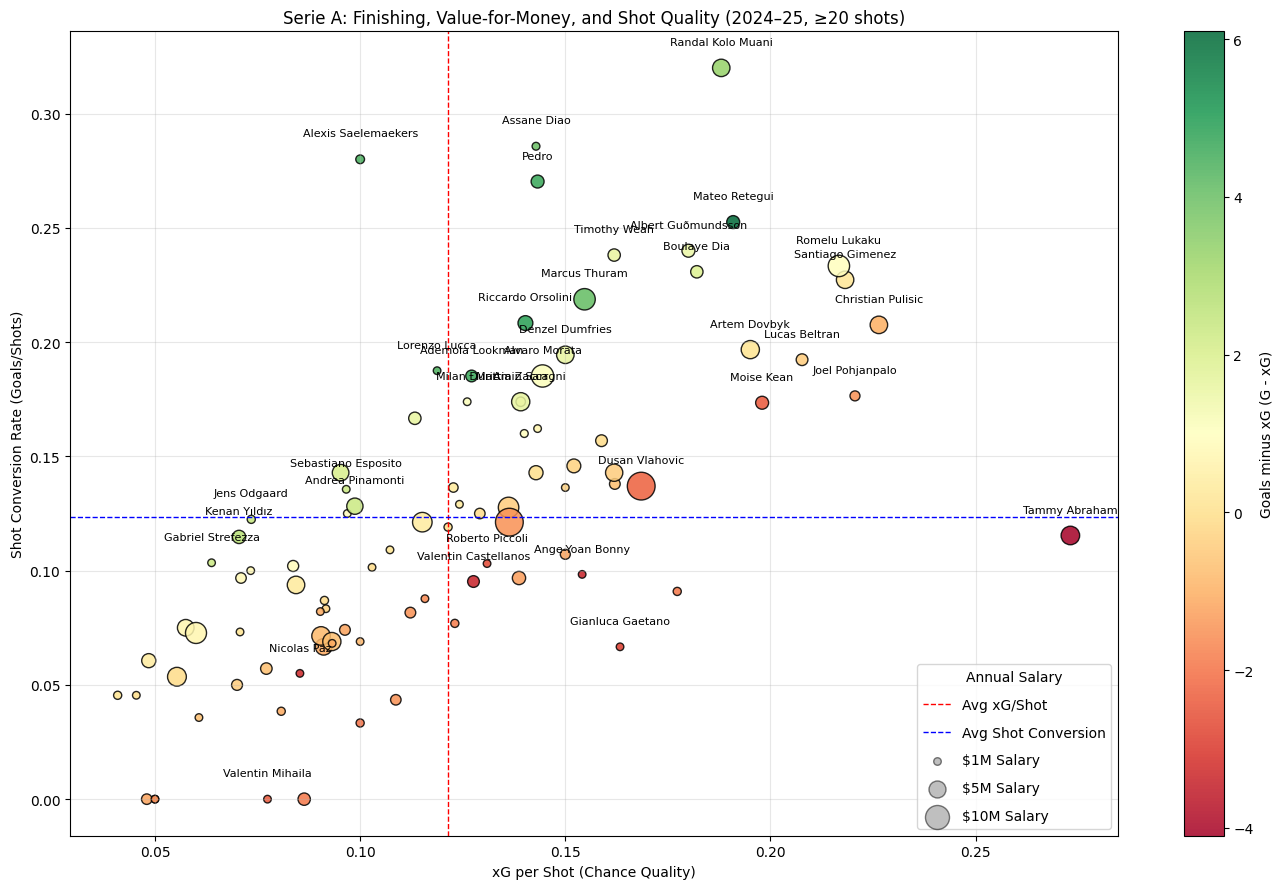

In [170]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14,9))

# Dot size: smaller dots for low salary, bigger for high
salary_sizes = np.clip(df_all_value['Salary_M_USD'].fillna(0)*30, 30, 400)  # scale to taste

cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(df_all_value['G_minus_xG'].min(), df_all_value['G_minus_xG'].max())

sc = plt.scatter(
    df_all_value['xG_per_shot'],
    df_all_value['Shot_Conversion'],
    s=salary_sizes,
    c=df_all_value['G_minus_xG'],
    cmap=cmap,
    norm=norm,
    alpha=0.85,
    edgecolor='k'
)

# Annotate selected players (e.g., those with high/low G-xG or standout value)
for _, row in df_all_value.iterrows():
    if (abs(row['G_minus_xG']) > 2 or row['Shot_Conversion'] > df_all_value['Shot_Conversion'].mean()+0.05) and row['Shots'] > 15:
        plt.text(
            row['xG_per_shot'],
            row['Shot_Conversion'] + 0.01,
            row['Player'].title(),
            fontsize=8,
            ha='center'
        )

plt.axvline(df_all_value['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(df_all_value['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A: Finishing, Value-for-Money, and Shot Quality (2024–25, ≥20 shots)')

# Colorbar for G-xG
cbar = plt.colorbar(sc)
cbar.set_label('Goals minus xG (G - xG)')

# Legend for salary bubble size
import matplotlib.lines as mlines
for s in [1, 5, 10]:
    plt.scatter([], [], s=s*30, c='gray', alpha=0.5, edgecolor='k', label=f'${s}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [173]:
df_all_value[df_all_value['Player'] == 'alexis saelemaekers']

Rk               Player  Nation    Pos Squad  Age  Born  Playing Time_MP  \
73  508  alexis saelemaekers  be BEL  DF,FW  roma   25  1999               22   

    Playing Time_Starts  Playing Time_Min  ...  Goals  Shots  SoT  \
73                   17              1389  ...      7     25   12   

    Goals_per90  Shot_Conversion  SoT_pct   xG  xG_per_shot  G_minus_xG  \
73     0.453564             0.28     0.48  2.5          0.1         4.5   

    Salary_M_USD  
73      1.319463  

[1 rows x 53 columns]

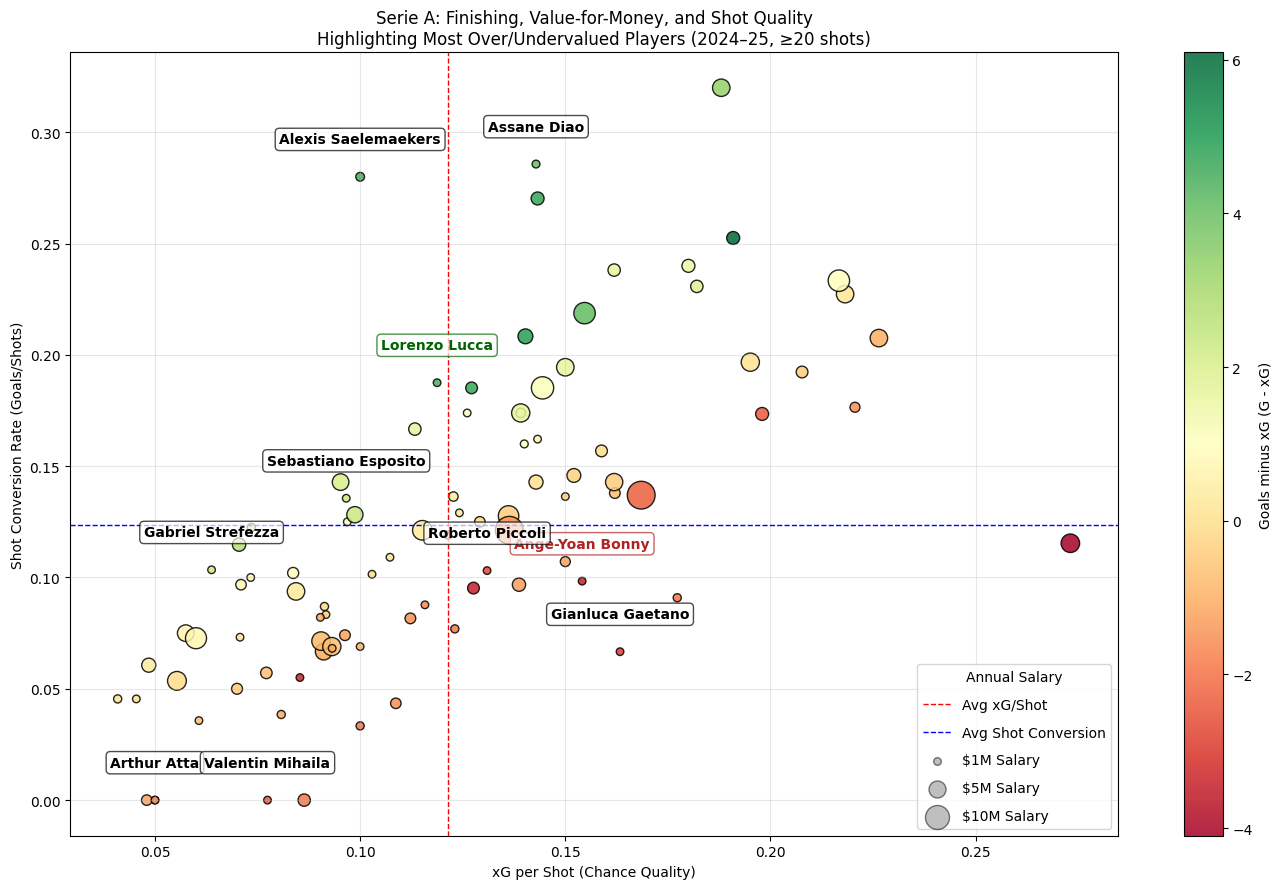

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Create value score (add a small number to denominator to avoid divide by zero)
df_all_value['Value_Score'] = df_all_value['G_minus_xG'] / (df_all_value['Salary_M_USD'] + 0.01)

# Select only players with at least 20 shots (to avoid tiny sample outliers)
eligible = df_all_value[df_all_value['Shots'] >= 20].copy()

# Get top 5 undervalued (highest value score) and top 5 overvalued (lowest)
top_undervalued = eligible.sort_values('Value_Score', ascending=False).head(5)
top_overvalued = eligible.sort_values('Value_Score').head(5)

# Combine for annotation
highlighted = pd.concat([top_undervalued, top_overvalued])

plt.figure(figsize=(14,9))

salary_sizes = np.clip(eligible['Salary_M_USD'].fillna(0)*30, 30, 400)
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(eligible['G_minus_xG'].min(), eligible['G_minus_xG'].max())

sc = plt.scatter(
    eligible['xG_per_shot'],
    eligible['Shot_Conversion'],
    s=salary_sizes,
    c=eligible['G_minus_xG'],
    cmap=cmap,
    norm=norm,
    alpha=0.85,
    edgecolor='k'
)

# Annotate only top undervalued and overvalued
for _, row in highlighted.iterrows():
    color = 'darkgreen' if row['Value_Score'] == top_undervalued['Value_Score'].max() else \
            'firebrick' if row['Value_Score'] == top_overvalued['Value_Score'].min() else 'black'
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.015,
        row['Player'].title(),
        fontsize=10,
        fontweight='bold',
        color=color,
        ha='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white', alpha=0.7)
    )

plt.axvline(eligible['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(eligible['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A: Finishing, Value-for-Money, and Shot Quality\nHighlighting Most Over/Undervalued Players (2024–25, ≥20 shots)')

# Colorbar for G-xG
cbar = plt.colorbar(sc)
cbar.set_label('Goals minus xG (G - xG)')

# Bubble size legend for salary
for s in [1, 5, 10]:
    plt.scatter([], [], s=s*30, c='gray', alpha=0.5, edgecolor='k', label=f'${s}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


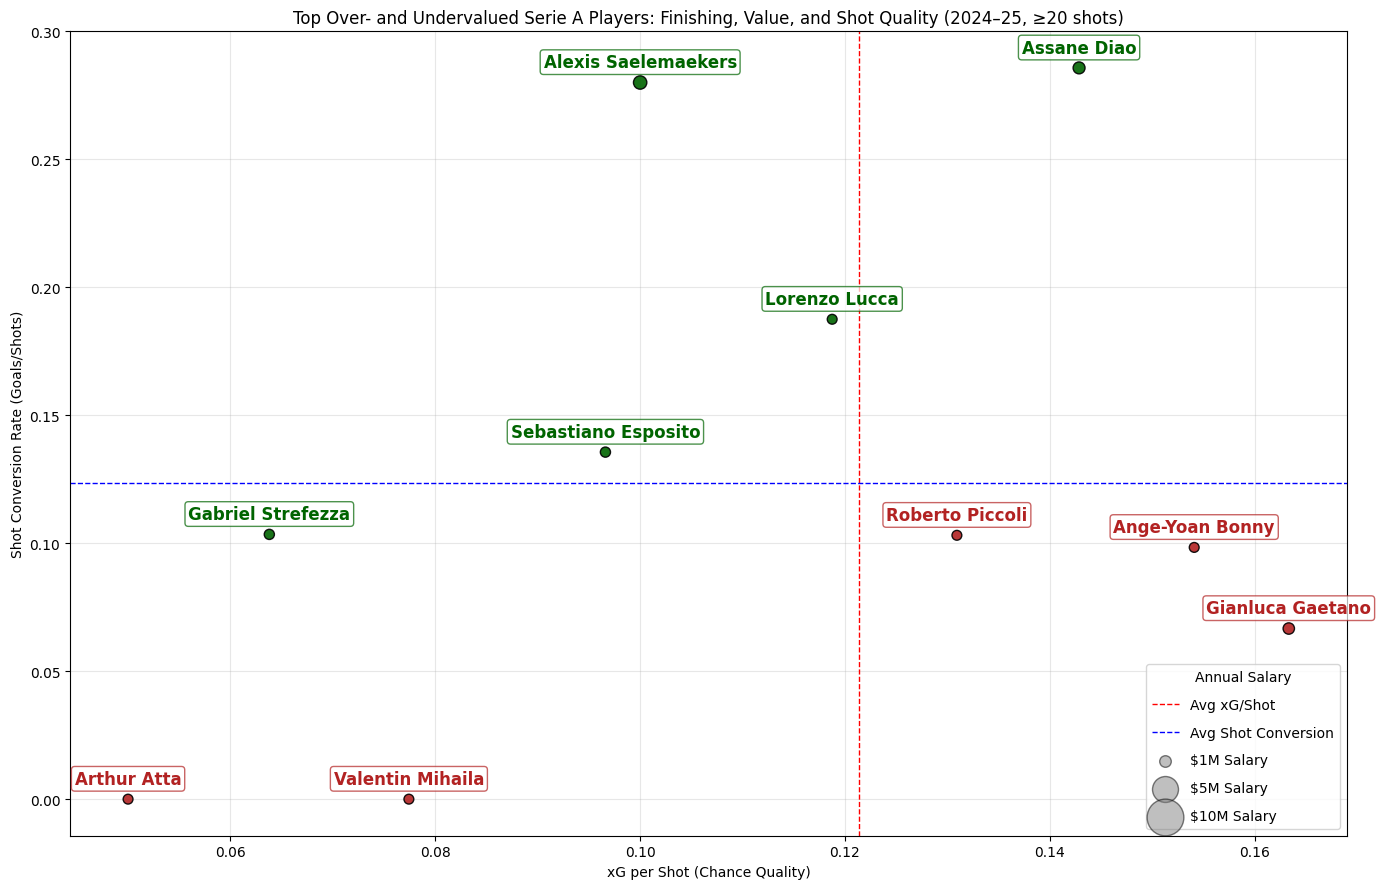

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure 'Value_Score' and highlights are defined as in the previous code
eligible = df_all_value[df_all_value['Shots'] >= 20].copy()
eligible['Value_Score'] = eligible['G_minus_xG'] / (eligible['Salary_M_USD'] + 0.01)
top_undervalued = eligible.sort_values('Value_Score', ascending=False).head(5)
top_overvalued = eligible.sort_values('Value_Score').head(5)
highlighted = pd.concat([top_undervalued, top_overvalued])

plt.figure(figsize=(14,9))

salary_sizes = np.clip(highlighted['Salary_M_USD'].fillna(0)*70, 50, 800)  # Bigger for small group

# Color: green for undervalued, red for overvalued
colors = ['darkgreen']*5 + ['firebrick']*5

sc = plt.scatter(
    highlighted['xG_per_shot'],
    highlighted['Shot_Conversion'],
    s=salary_sizes,
    c=colors,
    alpha=0.9,
    edgecolor='k',
    zorder=3
)

# Annotate, closer to bubble (smaller offset)
for i, (_, row) in enumerate(highlighted.iterrows()):
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.006,   # Smaller offset!
        row['Player'].title(),
        fontsize=12,
        fontweight='bold',
        color=colors[i],
        ha='center',
        bbox=dict(boxstyle="round,pad=0.2", edgecolor=colors[i], facecolor='white', alpha=0.7),
        zorder=4
    )

plt.axvline(eligible['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(eligible['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Top Over- and Undervalued Serie A Players: Finishing, Value, and Shot Quality (2024–25, ≥20 shots)')

# Bubble size legend for salary
for s in [1, 5, 10]:
    plt.scatter([], [], s=s*70, c='gray', alpha=0.5, edgecolor='k', label=f'${s}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()


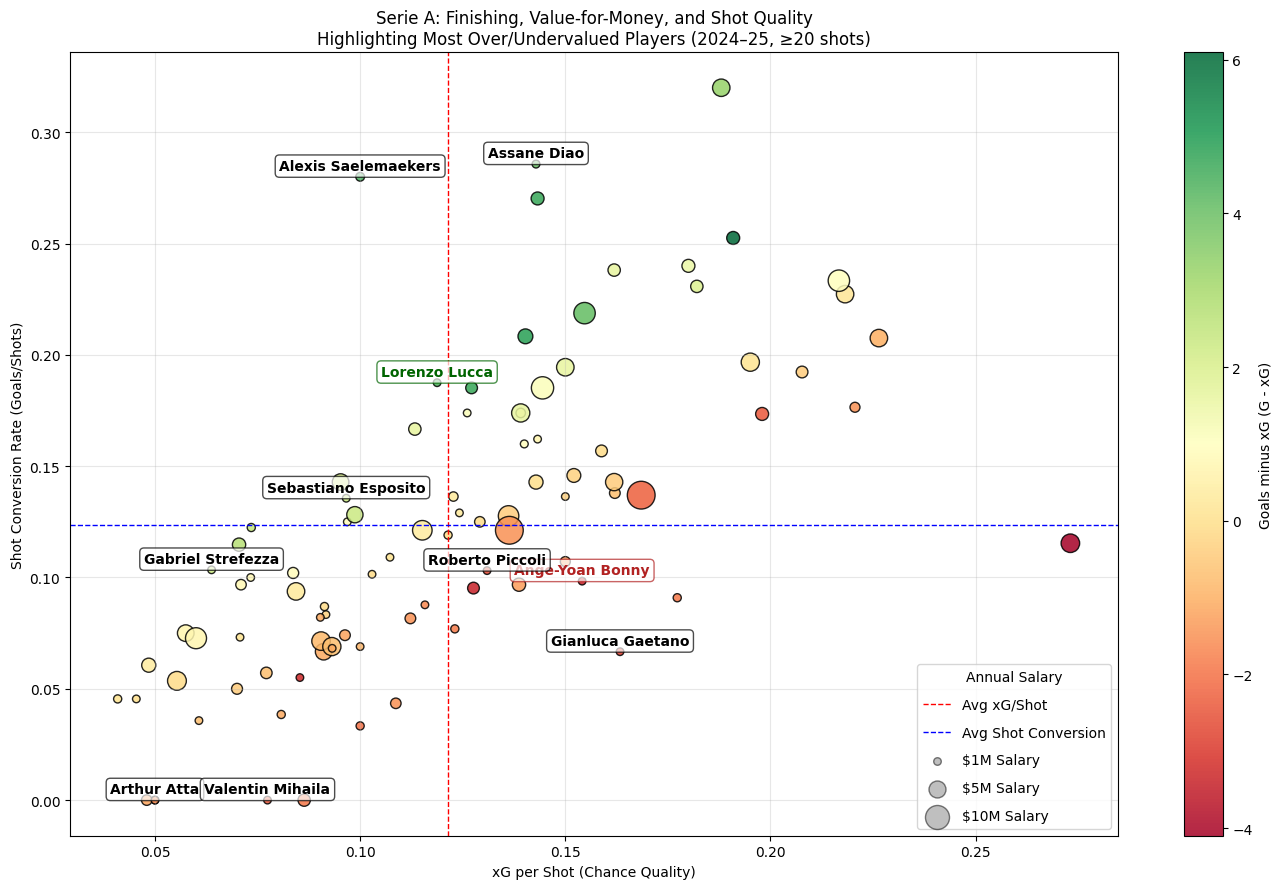

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate value score (avoid div by zero)
df_all_value['Value_Score'] = df_all_value['G_minus_xG'] / (df_all_value['Salary_M_USD'] + 0.01)
eligible = df_all_value[df_all_value['Shots'] >= 20].copy()
top_undervalued = eligible.sort_values('Value_Score', ascending=False).head(5)
top_overvalued = eligible.sort_values('Value_Score').head(5)
highlighted = pd.concat([top_undervalued, top_overvalued])

plt.figure(figsize=(14,9))
salary_sizes = np.clip(eligible['Salary_M_USD'].fillna(0)*30, 30, 400)
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(eligible['G_minus_xG'].min(), eligible['G_minus_xG'].max())

sc = plt.scatter(
    eligible['xG_per_shot'],
    eligible['Shot_Conversion'],
    s=salary_sizes,
    c=eligible['G_minus_xG'],
    cmap=cmap,
    norm=norm,
    alpha=0.85,
    edgecolor='k'
)

# Annotate only top undervalued and overvalued
for _, row in highlighted.iterrows():
    color = 'darkgreen' if row['Value_Score'] == top_undervalued['Value_Score'].max() else \
            'firebrick' if row['Value_Score'] == top_overvalued['Value_Score'].min() else 'black'
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.003,   # <-- SMALLER offset for closer labels!
        row['Player'].title(),
        fontsize=10,
        fontweight='bold',
        color=color,
        ha='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white', alpha=0.7)
    )

plt.axvline(eligible['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(eligible['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A: Finishing, Value-for-Money, and Shot Quality\nHighlighting Most Over/Undervalued Players (2024–25, ≥20 shots)')

# Colorbar for G-xG
cbar = plt.colorbar(sc)
cbar.set_label('Goals minus xG (G - xG)')

# Bubble size legend for salary
for s in [1, 5, 10]:
    plt.scatter([], [], s=s*30, c='gray', alpha=0.5, edgecolor='k', label=f'${s}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [177]:
# Define high/low salary thresholds
top_salary = eligible.sort_values('Salary_M_USD', ascending=False).head(3)
low_salary = eligible.sort_values('Salary_M_USD', ascending=True).head(3)

# Salary-to-performance (goals per million salary)
eligible['Goals_per_Million'] = eligible['Goals'] / (eligible['Salary_M_USD'] + 0.01)
best_value = eligible.sort_values('Goals_per_Million', ascending=False).head(3)
worst_value = eligible.sort_values('Goals_per_Million').head(3)

# Combine all unique players to annotate (by index to avoid duplicates)
highlighted = pd.concat([
    top_undervalued,
    top_overvalued,
    top_salary,
    low_salary,
    best_value,
    worst_value
]).drop_duplicates(subset=['Player', 'Squad'])


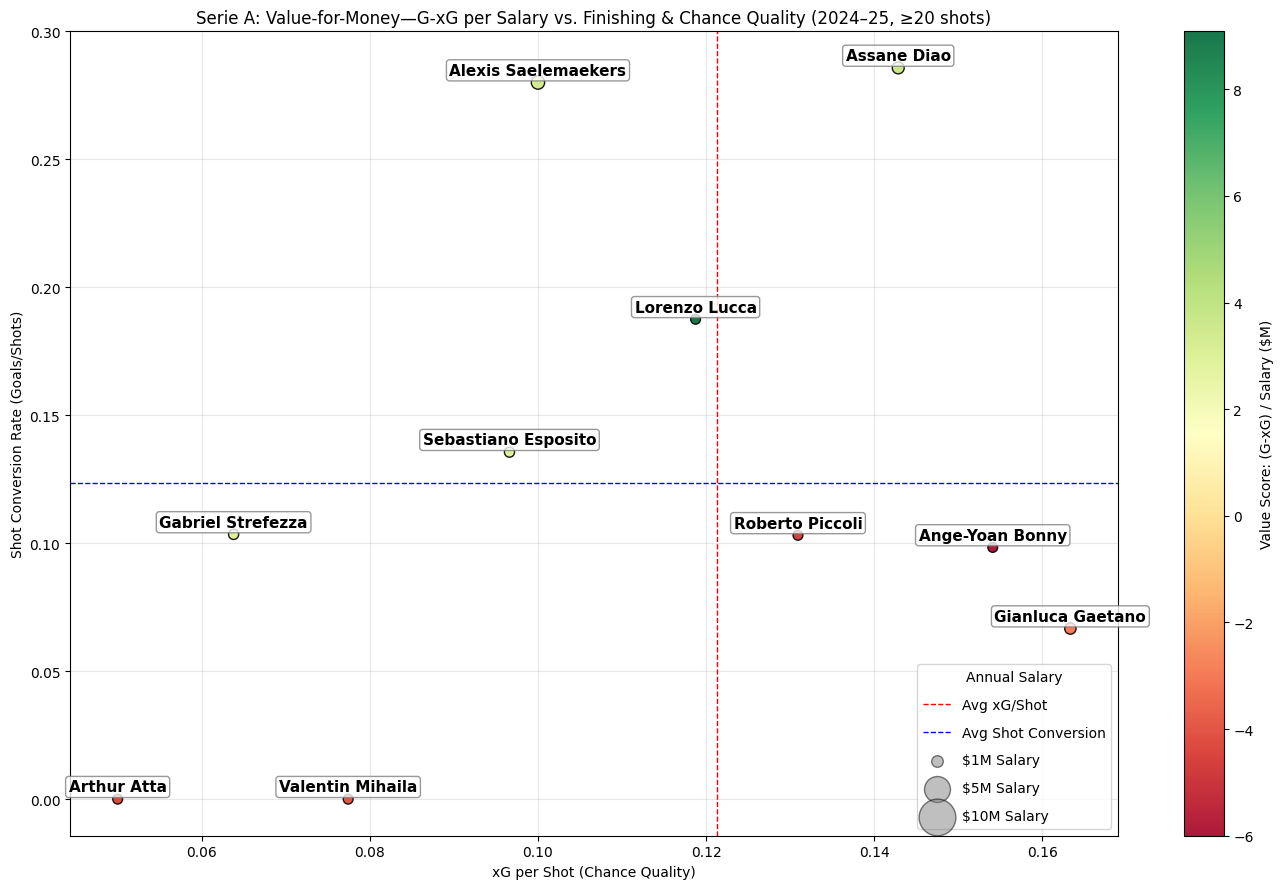

In [189]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate Value_Score if not already present
eligible = df_all_value[df_all_value['Shots'] >= 20].copy()
eligible['Value_Score'] = eligible['G_minus_xG'] / (eligible['Salary_M_USD'] + 0.01)  # Avoid div/0

# Pick your highlights (e.g., top/bottom value, or top earners)
highlighted = pd.concat([
    eligible.sort_values('Value_Score', ascending=False).head(5),
    eligible.sort_values('Value_Score').head(5)
]).drop_duplicates(subset=['Player', 'Squad'])

plt.figure(figsize=(14,9))
salary_sizes = np.clip(highlighted['Salary_M_USD'].fillna(0)*70, 50, 800)

# Color by Value_Score!
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(eligible['Value_Score'].min(), eligible['Value_Score'].max())

sc = plt.scatter(
    highlighted['xG_per_shot'],
    highlighted['Shot_Conversion'],
    s=salary_sizes,
    c=highlighted['Value_Score'],
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolor='k',
    zorder=3
)

# Annotate
for _, row in highlighted.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.003,
        row['Player'].title(),
        fontsize=11,
        fontweight='bold',
        color='black',
        ha='center',
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='gray', facecolor='white', alpha=0.8),
        zorder=4
    )

plt.axvline(eligible['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(eligible['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A: Value-for-Money—G-xG per Salary vs. Finishing & Chance Quality (2024–25, ≥20 shots)')

# Colorbar for Value_Score
cbar = plt.colorbar(sc)
cbar.set_label('Value Score: (G-xG) / Salary ($M)')

# Bubble size legend for salary
for s in [1, 5, 10]:
    plt.scatter([], [], s=s*70, c='gray', alpha=0.5, edgecolor='k', label=f'${s}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()


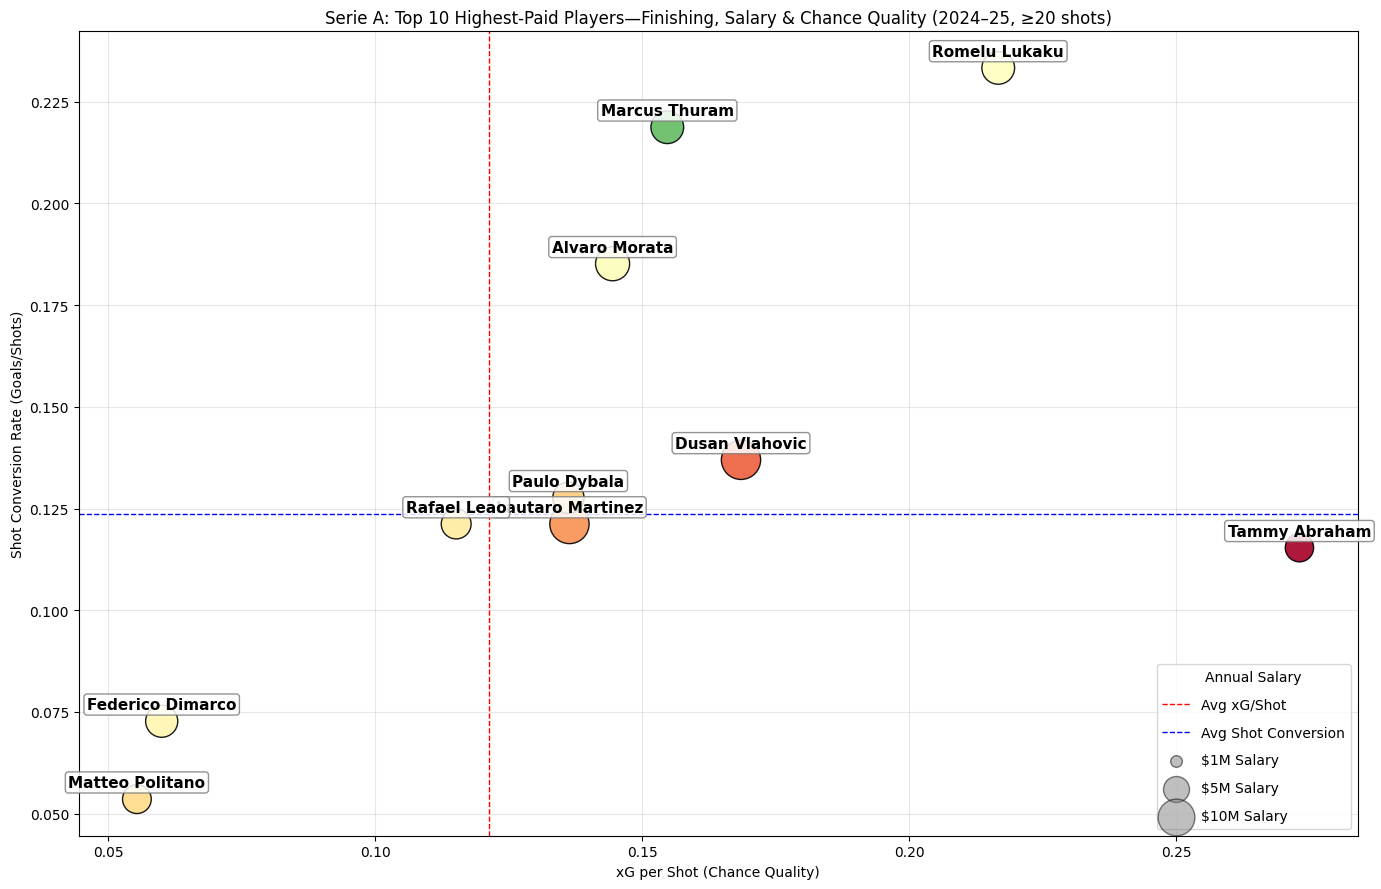

In [182]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure Value_Score is calculated
eligible = df_all_value[df_all_value['Shots'] >= 20].copy()
top_salary = eligible.sort_values('Salary_M_USD', ascending=False).head(10)

plt.figure(figsize=(14,9))

salary_sizes = np.clip(top_salary['Salary_M_USD'].fillna(0)*70, 50, 800)

# Use color for G_minus_xG (green = overperform, red = underperform)
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(eligible['G_minus_xG'].min(), eligible['G_minus_xG'].max())
colors = cmap(norm(top_salary['G_minus_xG']))

sc = plt.scatter(
    top_salary['xG_per_shot'],
    top_salary['Shot_Conversion'],
    s=salary_sizes,
    c=colors,
    alpha=0.9,
    edgecolor='k',
    zorder=3
)

# Annotate all top earners
for _, row in top_salary.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.003,
        row['Player'].title(),
        fontsize=11,
        fontweight='bold',
        color='black',
        ha='center',
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='gray', facecolor='white', alpha=0.85),
        zorder=4
    )

plt.axvline(eligible['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(eligible['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A: Top 10 Highest-Paid Players—Finishing, Salary & Chance Quality (2024–25, ≥20 shots)')

# Bubble size legend for salary
for s in [1, 5, 10]:
    plt.scatter([], [], s=s*70, c='gray', alpha=0.5, edgecolor='k', label=f'${s}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()


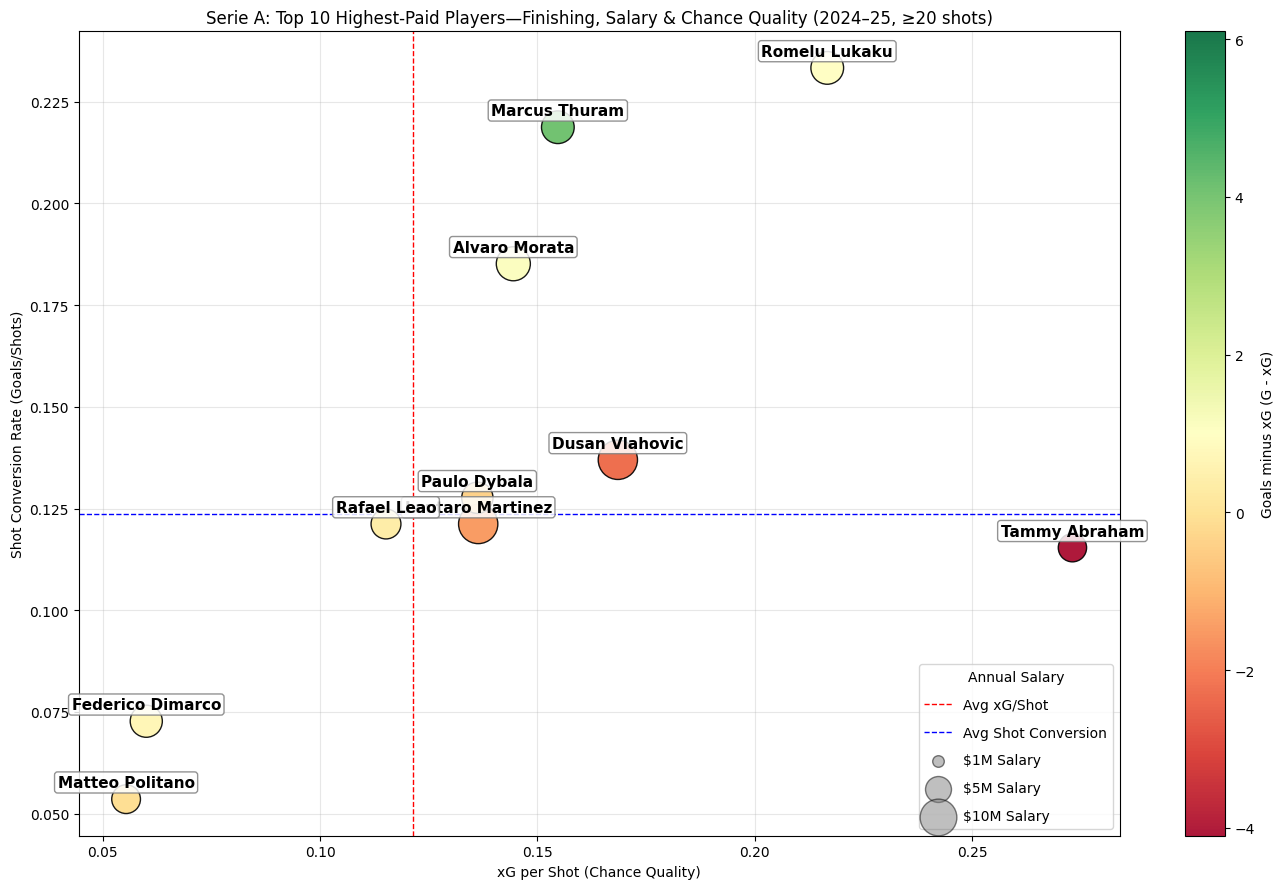

In [186]:
import matplotlib.pyplot as plt
import numpy as np

eligible = df_all_value[df_all_value['Shots'] >= 20].copy()
top_salary = eligible.sort_values('Salary_M_USD', ascending=False).head(10)

plt.figure(figsize=(14,9))
salary_sizes = np.clip(top_salary['Salary_M_USD'].fillna(0)*70, 50, 800)
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(eligible['G_minus_xG'].min(), eligible['G_minus_xG'].max())

sc = plt.scatter(
    top_salary['xG_per_shot'],
    top_salary['Shot_Conversion'],
    s=salary_sizes,
    c=top_salary['G_minus_xG'],   # <--- THIS
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolor='k',
    zorder=3
)

# Annotate
for _, row in top_salary.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.003,
        row['Player'].title(),
        fontsize=11,
        fontweight='bold',
        color='black',
        ha='center',
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='gray', facecolor='white', alpha=0.85),
        zorder=4
    )

plt.axvline(eligible['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(eligible['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A: Top 10 Highest-Paid Players—Finishing, Salary & Chance Quality (2024–25, ≥20 shots)')

# Colorbar for G-xG
cbar = plt.colorbar(sc)
cbar.set_label('Goals minus xG (G - xG)')

# Bubble size legend for salary
for s in [1, 5, 10]:
    plt.scatter([], [], s=s*70, c='gray', alpha=0.5, edgecolor='k', label=f'${s}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()


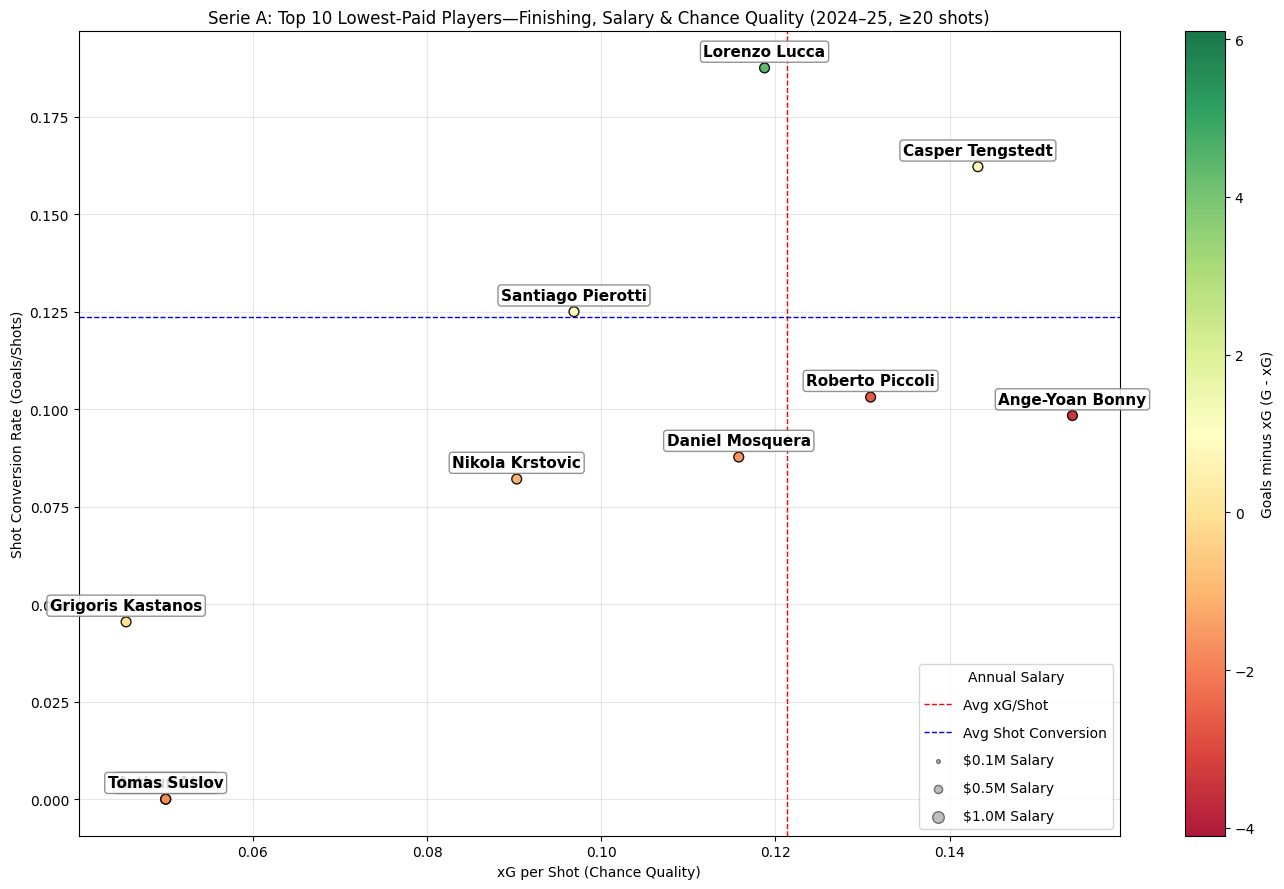

In [187]:
import matplotlib.pyplot as plt
import numpy as np

eligible = df_all_value[df_all_value['Shots'] >= 20].copy()
low_salary = eligible.sort_values('Salary_M_USD', ascending=True).head(10)

plt.figure(figsize=(14,9))
salary_sizes = np.clip(low_salary['Salary_M_USD'].fillna(0)*70, 50, 800)
cmap = plt.get_cmap('RdYlGn')
norm = plt.Normalize(eligible['G_minus_xG'].min(), eligible['G_minus_xG'].max())

sc = plt.scatter(
    low_salary['xG_per_shot'],
    low_salary['Shot_Conversion'],
    s=salary_sizes,
    c=low_salary['G_minus_xG'],    # Color by finishing value
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolor='k',
    zorder=3
)

# Annotate
for _, row in low_salary.iterrows():
    plt.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.003,
        row['Player'].title(),
        fontsize=11,
        fontweight='bold',
        color='black',
        ha='center',
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='gray', facecolor='white', alpha=0.85),
        zorder=4
    )

plt.axvline(eligible['xG_per_shot'].mean(), color='red', linestyle='--', linewidth=1, label='Avg xG/Shot')
plt.axhline(eligible['Shot_Conversion'].mean(), color='blue', linestyle='--', linewidth=1, label='Avg Shot Conversion')
plt.xlabel('xG per Shot (Chance Quality)')
plt.ylabel('Shot Conversion Rate (Goals/Shots)')
plt.title('Serie A: Top 10 Lowest-Paid Players—Finishing, Salary & Chance Quality (2024–25, ≥20 shots)')

# Colorbar for G-xG
cbar = plt.colorbar(sc)
cbar.set_label('Goals minus xG (G - xG)')

# Bubble size legend for salary
for s in [0.1, 0.5, 1]:
    plt.scatter([], [], s=s*70, c='gray', alpha=0.5, edgecolor='k', label=f'${s:.1f}M Salary')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Annual Salary', loc='lower right')

plt.grid(alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()
